# Long Notebook - Active

#### Emil B. Berglund - 529222 & Louis H. H. Linnerud - 539305, Team: Noe Lættis 

#### Table of contents:
1. Exploratory data analysis
2. Feature Engineering 
3. Models/Predictors
    - LightGBM
    - Random Forest Regressor
4. Model Interpretations
    - feature importance
5. Improved models (possibly)



# ___________ _0. Setup_ ___________

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble
import optuna
import lightgbm as lgb
import catboost as cb
import xgboost as xg
import featuretools as ft
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from verstack import LGBMTuner, MeanTargetEncoder, OneHotEncoder
import shap



#from pandas_profiling import ProfileReport

In [2]:
def writeResultToFile(test_data, pred_data, nameOfFile='namelessSubmission'):
    submission = pd.DataFrame()
    submission['id'] = test_data['store_id']
    submission['predicted'] = np.asarray(pred_data)
    submission.to_csv('submissionFiles/'+ nameOfFile+'.csv', index=False)
    

In [3]:
def rmsle(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred)**0.5

# ___________ _1. Exploratory Data Analysis_ ___________


#### Domain Knowledge

Retailers obviously earn their revenue from sales, different retailers sell different products to different customers. Different products have different margins and number of sales, directly impacting the revenue. Number of sales most likely have a high correlation with number of costumers, areas with a high population density will therefor most likely have a higher number of customers, impacting number of sales and then impacting the revenue. Therefor retailer type and geographical position most likely have a high impact on revenue. Only knowing those two attributes can be a good pin pointer, but not necessary enough as described in this article: https://carto.com/blog/retail-revenue-prediction-data-science/. Area infrastructure, retailer reputation, market competition, inventory managements, customer type, sales strategy and a lot more factors impact revenue and makes this problem complex. further reading on some of these factors: https://smallbusiness.chron.com/calculate-percentage-profit-markups-business-60099.html


#### Is the data intuitiv?

As can be seen below, data is organized in rows, where each row represents a single retailer with its relevant attributes and revenue. The stores train, extra and test data is intuitiv.

The different grunnkrets data was not super intuitv before some exploration was done, the same grunnkrets_id appeard more than once, but we shortly realized that this is because the measurment (example: average income) is done twice, once in 2015 and once in 2016.

In [4]:
stores_train = pd.read_csv('data/stores_train.csv')


In [5]:
stores_train.head()

store_id  year                           store_name  \
0   983540538-974187930-44774  2016  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755  2016           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491  2016                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912  2016        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469  2016             BURGER KING TILLERTORGET   

  plaace_hierarchy_id     sales_channel_name  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue  
0   17.998  
1   23.828  
2   16.099  
3    9.296  
4    4.528

In [6]:
stores_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12859 entries, 0 to 12858
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   store_id             12859 non-null  object 
 1   year                 12859 non-null  int64  
 2   store_name           12859 non-null  object 
 3   plaace_hierarchy_id  12859 non-null  object 
 4   sales_channel_name   12859 non-null  object 
 5   grunnkrets_id        12859 non-null  int64  
 6   address              11085 non-null  object 
 7   lat                  12859 non-null  float64
 8   lon                  12859 non-null  float64
 9   chain_name           3737 non-null   object 
 10  mall_name            2280 non-null   object 
 11  revenue              12859 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.2+ MB


In [7]:
stores_train.describe()

year  grunnkrets_id           lat           lon       revenue
count  12859.0   1.285900e+04  12859.000000  12859.000000  12859.000000
mean    2016.0   9.338697e+06     61.212166      9.995425      8.220683
std        0.0   5.788875e+06      2.965672      3.793565     15.377130
min     2016.0   1.010105e+06     57.994443      4.625889      0.000000
25%     2016.0   3.014208e+06     59.421935      7.284691      1.195000
50%     2016.0   9.065213e+06     59.939017     10.407916      3.374000
75%     2016.0   1.449011e+07     62.116531     10.848180      7.996000
max     2016.0   2.030031e+07     71.098287     31.118935    219.599000

In [8]:
#report = ProfileReport(stores_train)
#report

#### Explore individual features and pairs and groups

Explore revenue based on store type

In [9]:
len(stores_train.plaace_hierarchy_id.unique())

91

In [10]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

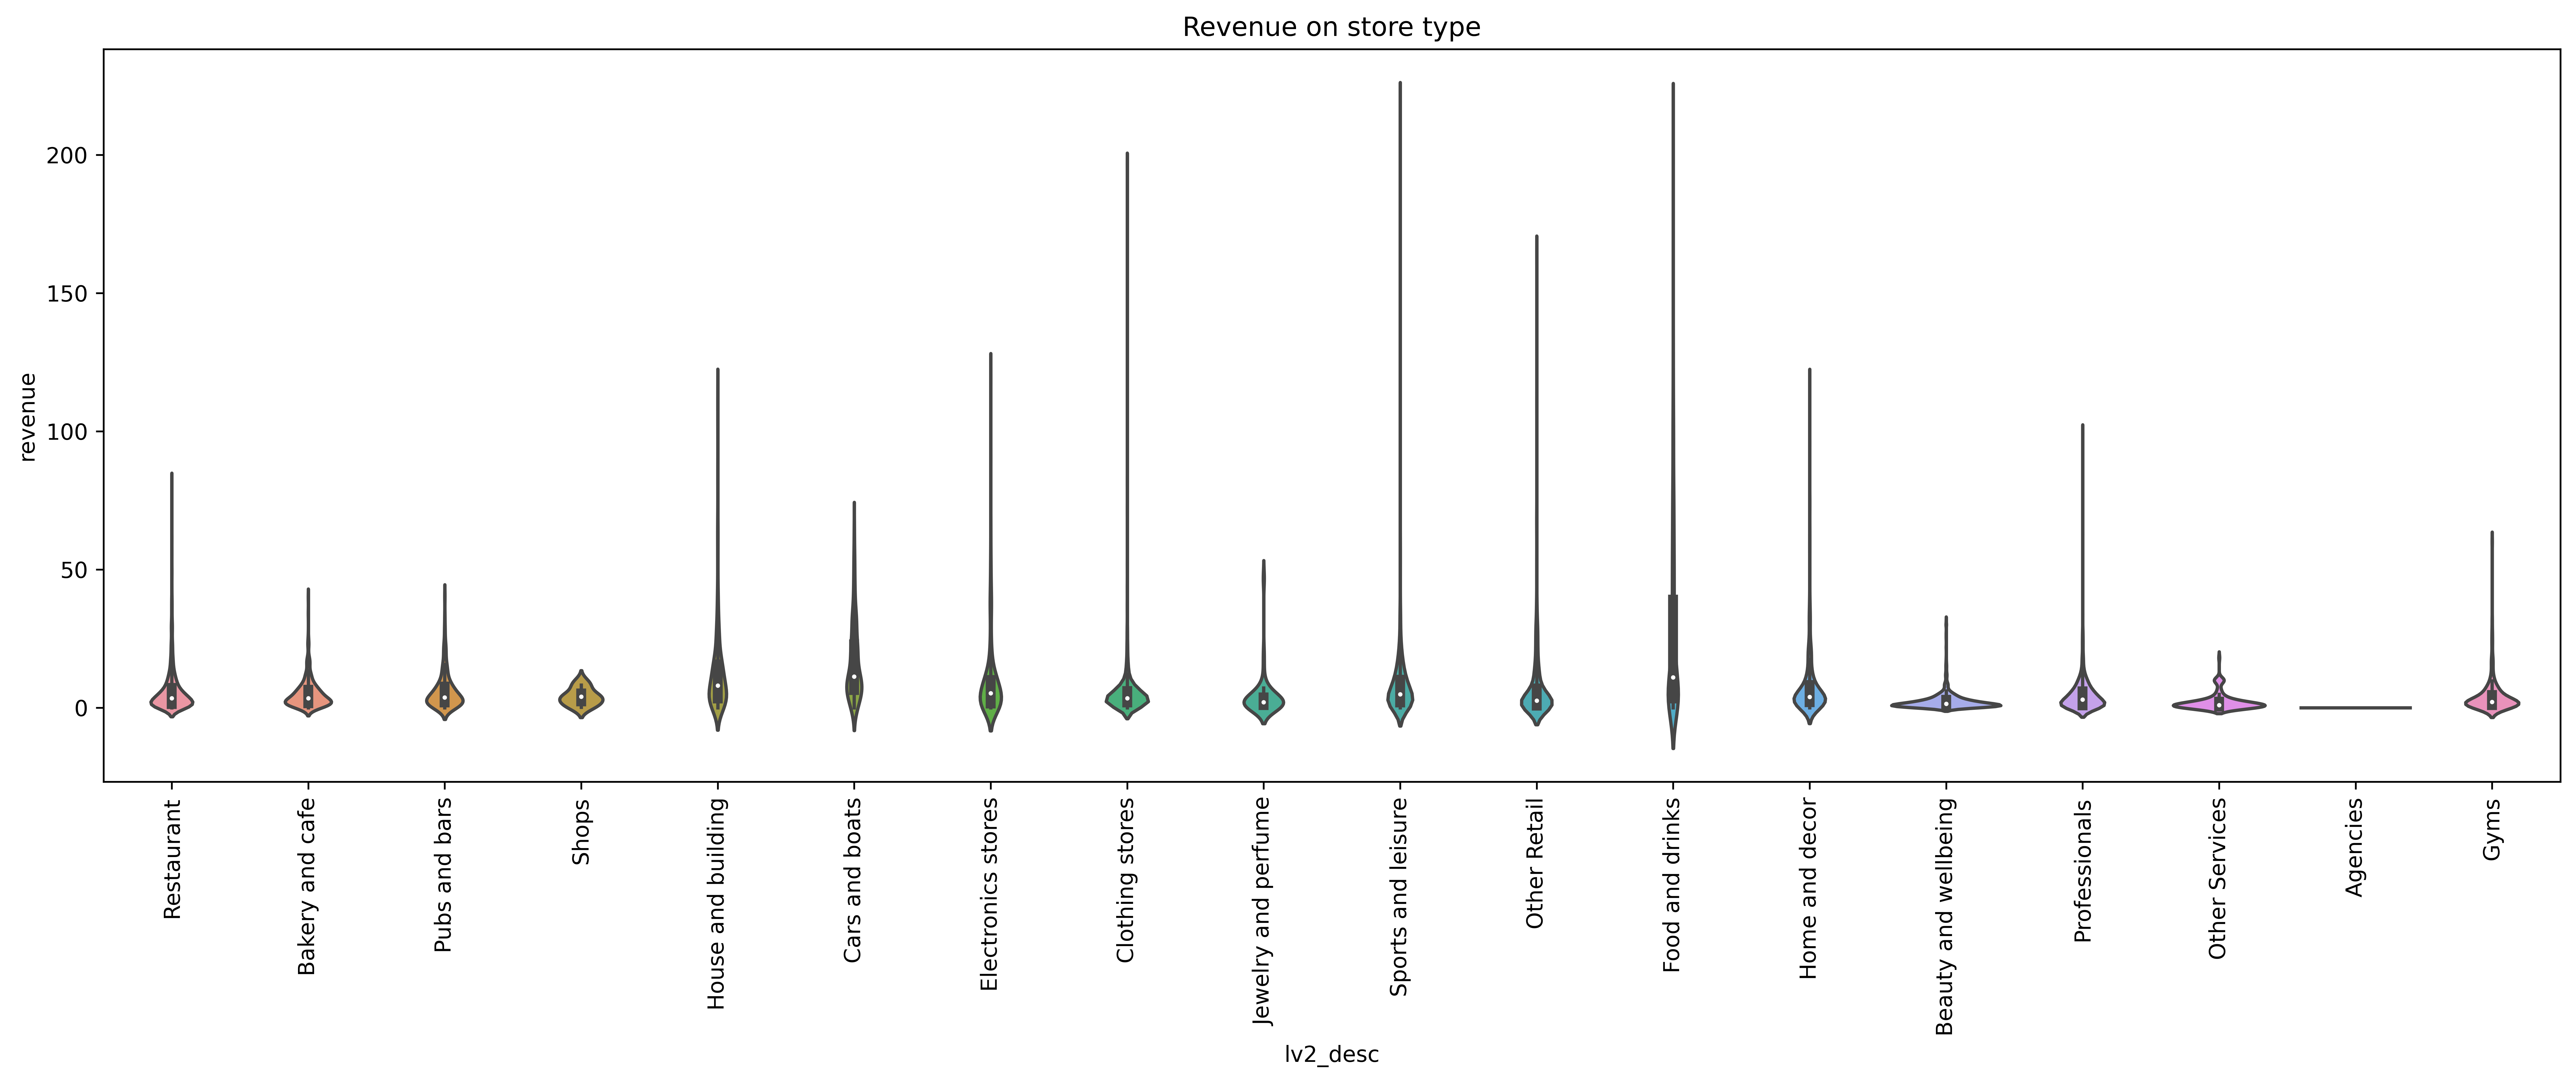

In [11]:
plt.figure(figsize=(20,6))
plt.gcf().set_dpi(600)
plt.xticks(rotation=90)
sns.violinplot(x='lv2_desc',y='revenue',data=stores_with_hierarchy).set_title("Revenue on store type")
plt.show()

further exploration of agencie store type

In [12]:
stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Agencies"]

store_id  year                     store_name  \
12442  915797512-915815782-782390  2016  RUUKKI BUILDING COMPONENTS AS   

      plaace_hierarchy_id  sales_channel_name_x  grunnkrets_id  \
12442             3.5.3.0  Advertising agencies        3014005   

                  address        lat        lon chain_name  ... revenue  \
12442  ØSTRE AKER VEI 219  59.948112  10.883745        NaN  ...     0.0   

       sales_channel_name_y lv1  lv1_desc  lv2  lv2_desc    lv3  \
12442  Advertising agencies   3  Services  3.5  Agencies  3.5.3   

                   lv3_desc      lv4              lv4_desc  
12442  Advertising agencies  3.5.3.0  Advertising agencies  

[1 rows x 21 columns]

Further exploration of "Food and drink" type stores


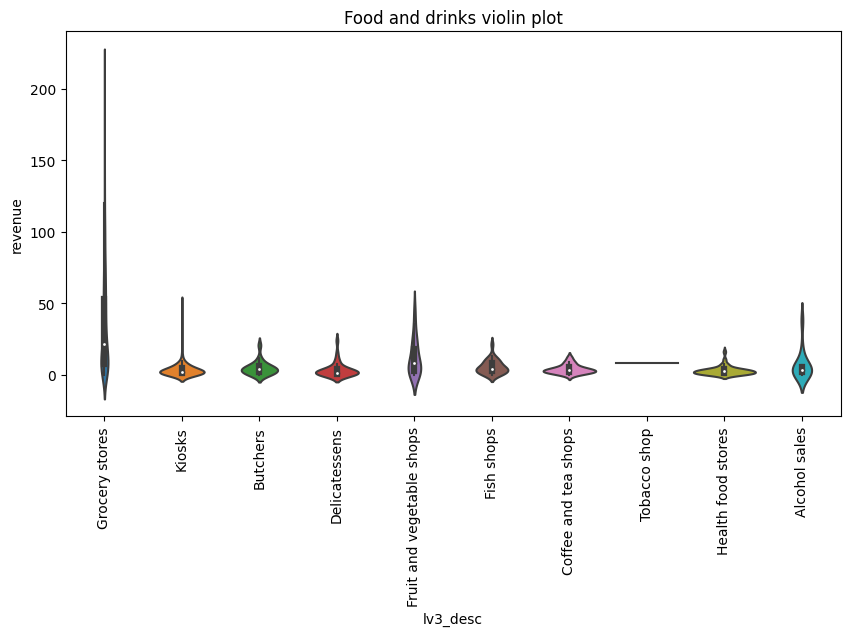

In [13]:
plt.figure(figsize=(10,5))
sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Food and drinks"]).set_title("Food and drinks violin plot")
plt.xticks(rotation=90)
plt.show()

Explore retailers with NaN, 0 or negative revenue

In [14]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]==0.0].describe()

year  grunnkrets_id         lat         lon  revenue         lv1  \
count   217.0   2.170000e+02  217.000000  217.000000    217.0  217.000000   
mean   2016.0   7.609318e+06   60.671650   10.007769      0.0    1.788018   
std       0.0   5.511516e+06    2.432534    3.006842      0.0    0.594141   
min    2016.0   1.040301e+06   58.029041    5.035586      0.0    1.000000   
25%    2016.0   3.010401e+06   59.559941    8.591472      0.0    1.000000   
50%    2016.0   6.020802e+06   59.919065   10.620743      0.0    2.000000   
75%    2016.0   1.201012e+07   60.394286   10.814440      0.0    2.000000   
max    2016.0   2.030030e+07   69.890997   30.043801      0.0    3.000000   

              lv2  
count  217.000000  
mean     2.188940  
std      0.758634  
min      1.100000  
25%      1.100000  
50%      2.400000  
75%      2.800000  
max      3.600000

In [15]:
stores_with_hierarchy[stores_with_hierarchy["revenue"] < 0.0].describe()

year  grunnkrets_id  lat  lon  revenue  lv1  lv2
count   0.0            0.0  0.0  0.0      0.0  0.0  0.0
mean    NaN            NaN  NaN  NaN      NaN  NaN  NaN
std     NaN            NaN  NaN  NaN      NaN  NaN  NaN
min     NaN            NaN  NaN  NaN      NaN  NaN  NaN
25%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
50%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
75%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
max     NaN            NaN  NaN  NaN      NaN  NaN  NaN

In [16]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]== np.nan].describe()

year  grunnkrets_id  lat  lon  revenue  lv1  lv2
count   0.0            0.0  0.0  0.0      0.0  0.0  0.0
mean    NaN            NaN  NaN  NaN      NaN  NaN  NaN
std     NaN            NaN  NaN  NaN      NaN  NaN  NaN
min     NaN            NaN  NaN  NaN      NaN  NaN  NaN
25%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
50%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
75%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
max     NaN            NaN  NaN  NaN      NaN  NaN  NaN

All retailers and their cooresponding revenue, the plot is to visually check for outliers, clearly there are som outliers as can be seen in the long tail to the right of the major distribution.
The data is clearly positively skewed, confirmed by the skew number printed above the plot

raw data skew: 4.759845139718512
log transform skew: 0.6787855811421601


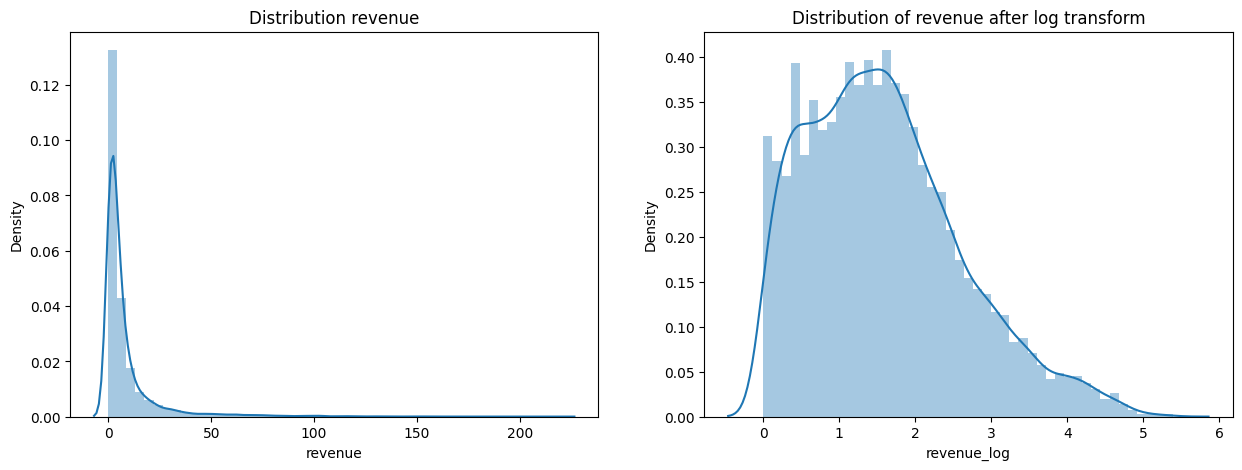

In [17]:
rev_log = pd.DataFrame()
rev_log['revenue_log'] = np.log1p(stores_train['revenue'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(stores_train['revenue'], ax=ax1);
ax1.set_title('Distribution revenue');
sns.distplot(rev_log['revenue_log'], ax=ax2);
ax2.set_title('Distribution of revenue after log transform');

print(f"raw data skew: {stores_train['revenue'].skew()}")
print(f"log transform skew: {rev_log['revenue_log'].skew()}")

### Cleaning

#### Remove columns function - example: year is a const value and has no effect on the end result

In [18]:
def remove_columns(dataSet, columns):
    for column in columns:
        dataSet.drop(column, axis=1, inplace=True)


In [19]:
remove_columns(stores_train,['year'])
stores_train.head()

store_id                           store_name  \
0   983540538-974187930-44774  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469             BURGER KING TILLERTORGET   

  plaace_hierarchy_id     sales_channel_name  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue  
0   17.998  
1   23.828  
2   16.099  
3    9.296  
4    4.528

#### Remove retailers with 0 revenue function - might be handy

In [20]:
def remove_retailers_with_0_revenue(dataSet):
    dataSet.drop(dataSet[dataSet['revenue']==0.0].index, inplace=True)

#### Removing outliers

Plotting all retailers based on storetype before and after trimming to confirm that outliers actually has been removed

Below is before trimming

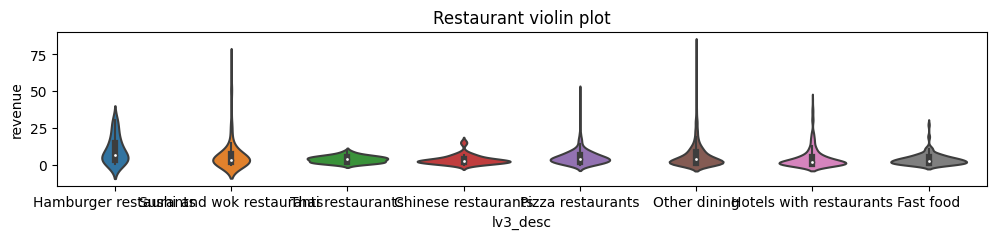

In [21]:
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()
    break #comment out for exploring more store types

Cap-outliers-function for the relationship between store type and revenue

In [22]:
def quantile_storeType_vs_revenue(stores, lower, upper):
    col_idx = stores.columns.get_loc('revenue')
    for store_type in stores['plaace_hierarchy_id'].unique():
        data = stores[stores['plaace_hierarchy_id']==store_type]
        upper_treshold = data['revenue'].quantile(upper)
        lower_treshold = data['revenue'].quantile(lower)
        #stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index, inplace=True)
        #stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index, inplace=True)
        
        stores.iloc[stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index,[col_idx]] = upper_treshold
        stores.iloc[stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index,[col_idx]] = lower_treshold
        
    

In [23]:
stores_train = pd.read_csv('data/stores_train.csv')
quantile_storeType_vs_revenue(stores_train,0.05,0.86)

Plot after removing outliers

you can see in the plot below that the outliers has been removed


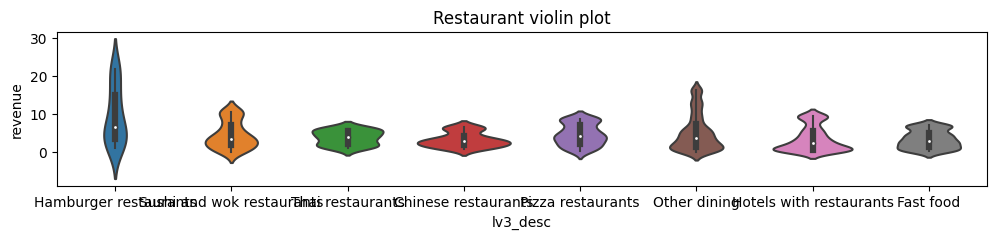

In [24]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()
    break #comment out for exploring more store types

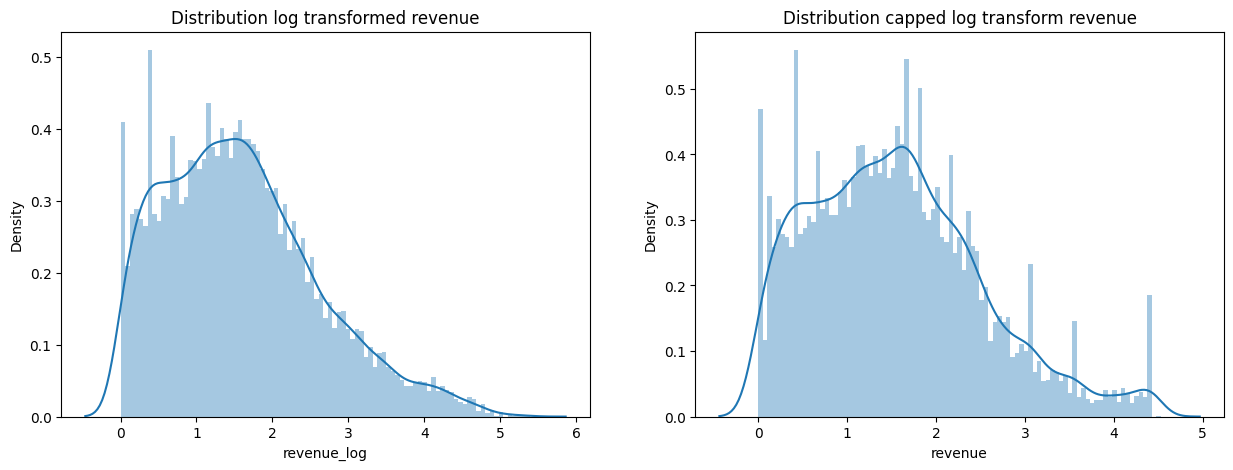

In [25]:
stores_train = pd.read_csv('data/stores_train.csv')
rev_log = pd.DataFrame()
rev_log['revenue_log'] = np.log1p(stores_train['revenue'])

rev_capped_log = stores_train.copy()
quantile_storeType_vs_revenue(rev_capped_log, 0.00, 0.90)
rev_capped_log['revenue'] = np.log1p(rev_capped_log['revenue'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(rev_log['revenue_log'], ax=ax1, bins=91);
ax1.set_title('Distribution log transformed revenue');
sns.distplot(rev_capped_log['revenue'], ax=ax2, bins=91);
ax2.set_title('Distribution capped log transform revenue');

Quantiling the data improved our predictions greatly in the beginning of the project, but we saw that it didnt have a noticable impact after we began exploring log transform, the plot above shows that quantiling does not improve distribution with log transform

#### compare store locations in test and train set

In [26]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

comparing coordinates

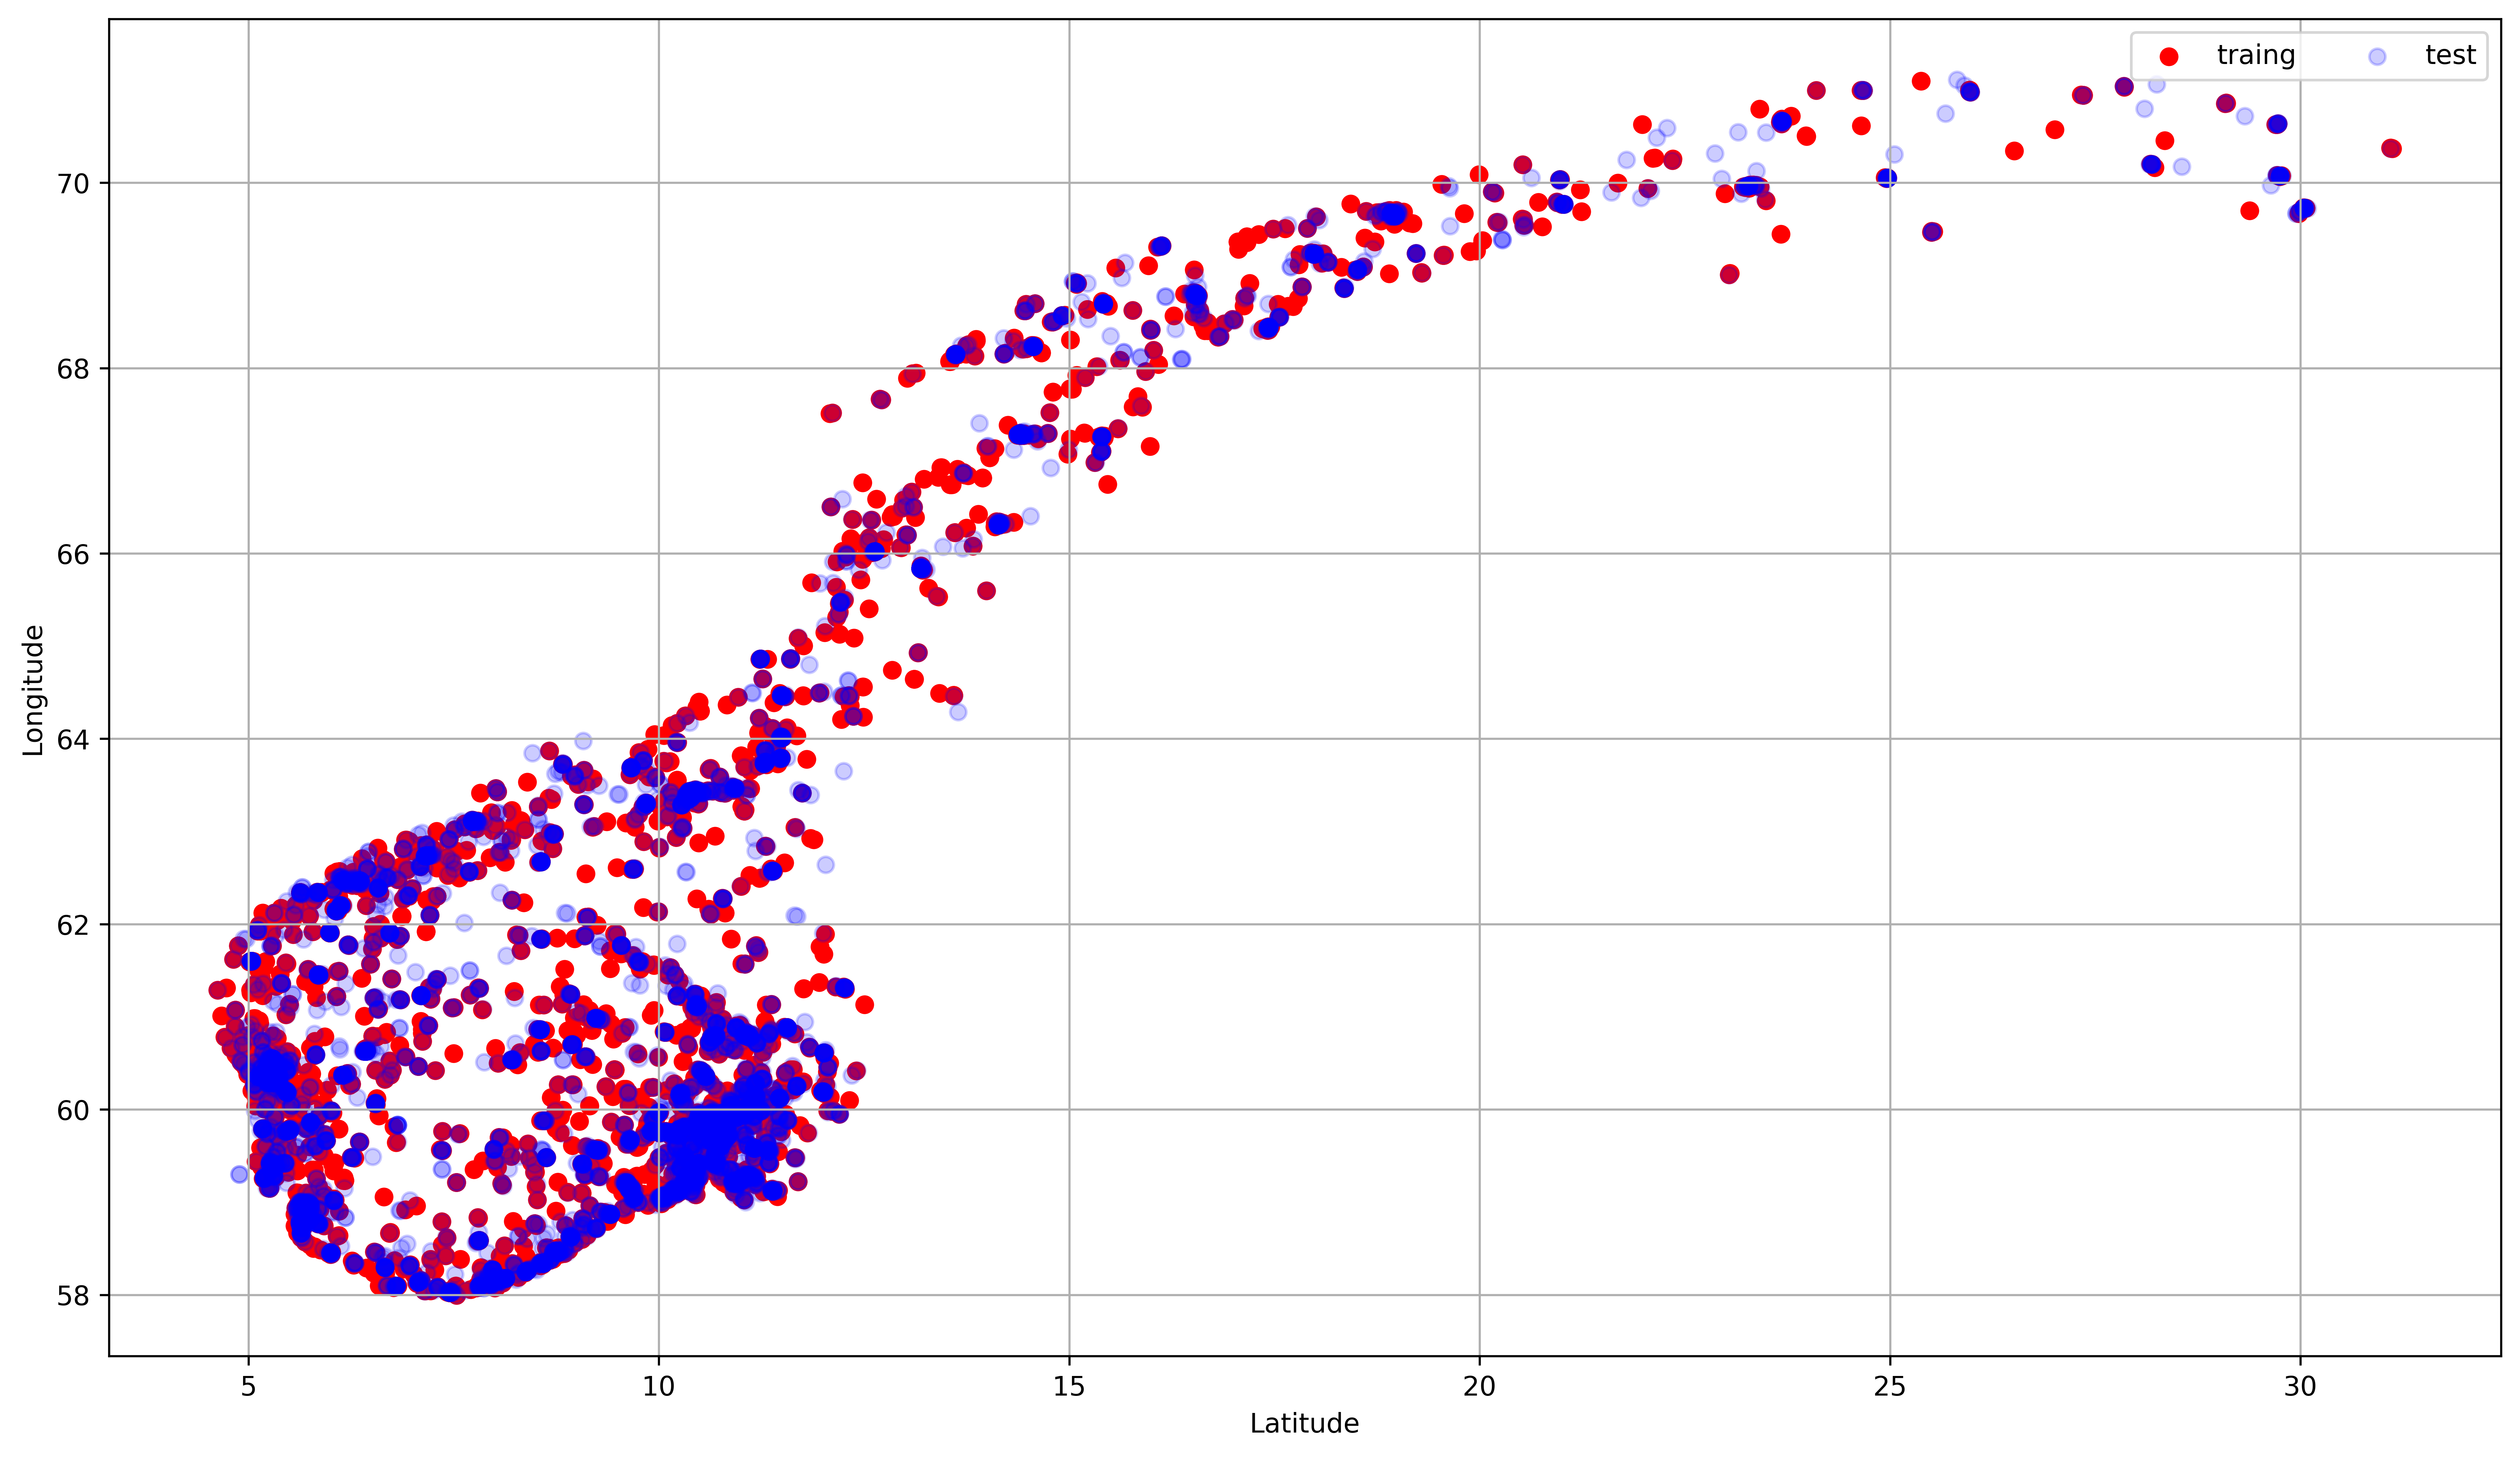

In [27]:
plt.figure(figsize=(16,9), dpi=600)
plt.scatter(stores_train['lon'],stores_train['lat'], label="traing",color='red')
plt.scatter(stores_test['lon'], stores_test['lat'], alpha=0.2, label="test", color="blue")
plt.legend(fontsize=10,ncol=2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.show()



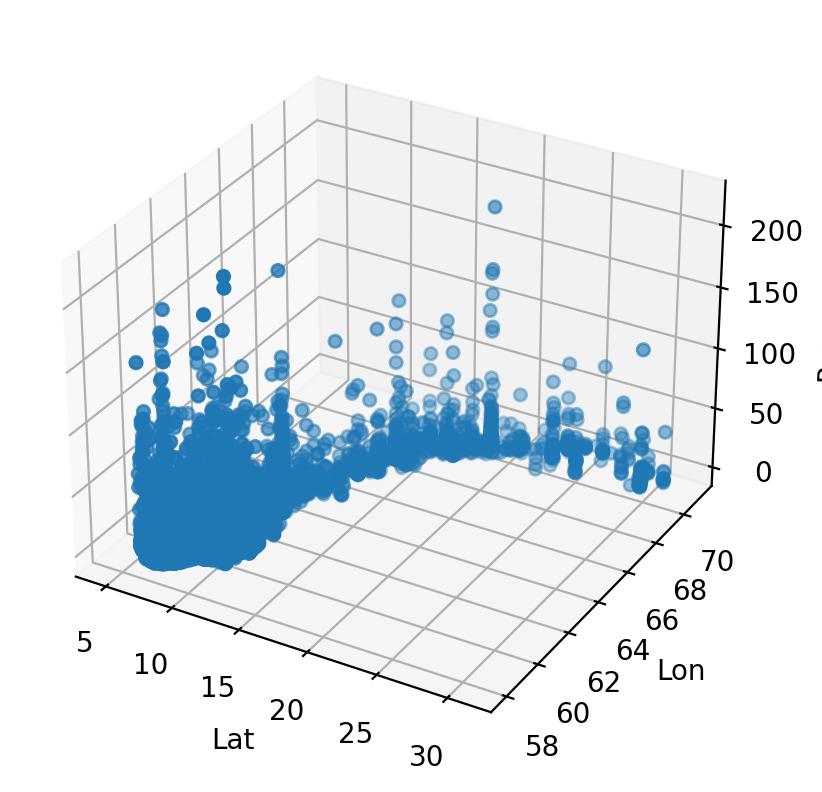

In [28]:
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(stores_train['lon'],stores_train['lat'],stores_train['revenue'])
ax1.set_xlabel('Lat')
ax1.set_ylabel('Lon')
ax1.set_zlabel('Revenue')
plt.show()


#### Examine whether a store occurs in multiple datasets 

In [29]:
def stores_that_are_in_both_sets(df1, df2):
    
    duplicate_set = pd.merge(df1,df2, how='inner', on='store_name')
    return duplicate_set

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_extra = pd.read_csv('data/stores_extra.csv')

dup = stores_that_are_in_both_sets(stores_test, stores_train)
dup.head()

store_id_x  year_x         store_name  \
0   988143294-888170332-16561    2016         YAYAS OSLO   
1  994905953-994946978-500374    2016         YAYAS OSLO   
2   913243730-871762422-46032    2016    MING RESTAURANT   
3  913594053-913748263-697094    2016   ALLEGRO PIZZERIA   
4    981126610-981131126-5363    2016  SPISERIET TRIADEN   

  plaace_hierarchy_id_x sales_channel_name_x  grunnkrets_id_x  \
0               1.1.3.0     Thai restaurants          3010905   
1               1.1.3.0     Thai restaurants          3010905   
2               1.1.4.0  Chinese restaurants          5010602   
3               1.1.5.0    Pizza restaurants         19021405   
4               1.1.6.2          Restaurants          2300312   

              address_x      lat_x      lon_x chain_name_x  ... year_y  \
0       INDUSTRIGATA 36  59.926040  10.719687     CONSELTO  ...   2016   
1       INDUSTRIGATA 36  59.926040  10.719687     CONSELTO  ...   2016   
2          STORGATA 130  61.120842  10.461641          NaN  ...   2016   
3     SOLSTRANDVEGEN 47  69.639962  18.970862          NaN  ...   2016   
4  ISAK H. WIIKS GATE 3  59.919147  10.952195          NaN  ...   2016   

  plaace_hierarchy_id_y  sales_channel_name_y grunnkrets_id_y  \
0               1.1.3.0      Thai restaurants         3010301   
1               1.1.3.0      Thai restaurants         3010301   
2               1.1.4.0   Chinese restaurants         1040504   
3               1.1.5.0     Pizza restaurants        19021404   
4               1.1.6.2           Restaurants         2300312   

              address_y      lat_y      lon_y  chain_name_y  \
0   MUNKEDAMSVEIEN 53 B  59.910977  10.722538      CONSELTO   
1   MUNKEDAMSVEIEN 53 B  59.910977  10.722538      CONSELTO   
2   DRONNINGENS GATE 27  59.435418  10.659777           NaN   
3        TURISTVEGEN 19  69.646103  18.991212           NaN   
4  ISAK H. WIIKS GATE 3  59.919147  10.952195           NaN   

                    mall_name_y revenue  
0                           NaN   9.233  
1                           NaN   9.233  
2                           NaN   6.484  
3                           NaN   4.609  
4  Triaden Lørenskog Storsenter   5.147  

[5 rows x 22 columns]

### Explore the other data sets

In [30]:
buss_stopps = pd.read_csv('data/busstops_norway.csv')
buss_stopps.head()

busstop_id                  stopplace_type  \
0  853cb081-cc32-4880-aa3e-26e96870d874              Plattform og lomme   
1  156b052b-2771-497a-b4f4-97fed59e1aca  Lomme og skilt, ikke plattform   
2  7312a280-e14f-4b09-a421-02e8fe1bc63e                             NaN   
3  d9cda2c7-355a-49c1-b56c-a33180d2a82e                             NaN   
4  f803bcd3-182d-450b-bbb4-113c6ca885c2                             NaN   

         importance_level  side_placement  \
0  Mangler viktighetsnivå  LEFT_AND_RIGHT   
1  Mangler viktighetsnivå  LEFT_AND_RIGHT   
2  Mangler viktighetsnivå     MIDDLE_LEFT   
3  Mangler viktighetsnivå     MIDDLE_LEFT   
4  Mangler viktighetsnivå    MIDDLE_RIGHT   

                                   geometry  
0  POINT(6.54064723379766 61.0618887850553)  
1  POINT(5.89980086113255 60.1421872817075)  
2  POINT(10.7781327278563 59.9299988828761)  
3  POINT(10.7781496457324 59.9301044643692)  
4  POINT(10.7781676444854 59.9302099995898)

In [31]:
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.head()

grunnkrets_id  year     grunnkrets_name          district_name  \
0       10010701  2015      Grim-Dueknipen  Grim-Møllevann-Dalane   
1       10010803  2015  Kvadraturen sørøst         Kvadraturen-Eg   
2       10020608  2015            Ormestad                  Holum   
3       10020901  2015              Tregde        Tregde-Skjernøy   
4       10030210  2015           Bryneheia             Vanse/Åpta   

  municipality_name                                           geometry  \
0      Kristiansand  MULTIPOLYGON(((7.97199691121304 58.14336769560...   
1      Kristiansand  POLYGON((8.00234207061135 58.1443514886041, 8....   
2            Mandal  POLYGON((7.48512808482995 58.0374976883392, 7....   
3            Mandal  MULTIPOLYGON(((7.50996051810658 58.02134863868...   
4           Farsund  POLYGON((6.70396719073296 58.0877854965615, 6....   

   area_km2  
0  0.768961  
1  0.361355  
2  0.280188  
3  0.156311  
4  0.791894

From exploring the the houshold income we can see that the distribution is somewhat negatively skewed but very evenly distributed, probably no need for any log transformation of this feature

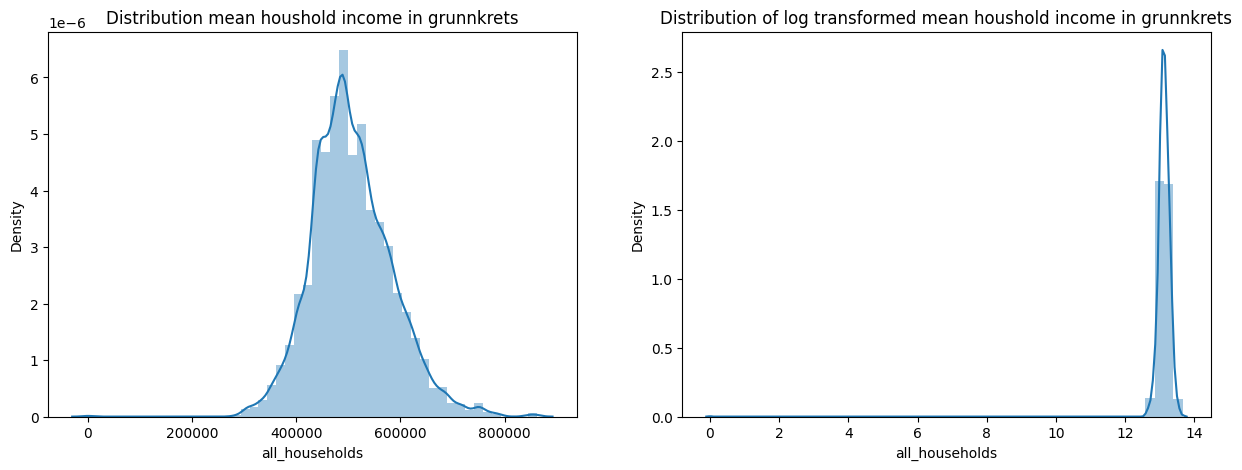

grunnkrets_id  year  all_households  singles  couple_without_children  \
0       14200105  2016          551700   270300                        0   
1        2311202  2015          577700   311800                        0   
2        2310501  2015          668800   292500                        0   
3       14200401  2016          507000   250700                        0   
4       14200105  2015          539900   275800                        0   

   couple_with_children  other_households  single_parent_with_children  \
0                     0                 0                            0   
1                682300                 0                            0   
2                842000                 0                            0   
3                     0                 0                            0   
4                710300                 0                            0   

  income_classification  
0                  high  
1                  high  
2                  high  
3                medium  
4                  high

In [32]:
gk_incomes = pd.read_csv('data/grunnkrets_income_households.csv')

upper_33 = gk_incomes['all_households'].quantile(0.67)
lower_33 = gk_incomes['all_households'].quantile(0.33)
maximum = gk_incomes['all_households'].max()
gk_incomes['income_classification'] = pd.cut(gk_incomes.all_households, bins=[0,lower_33, upper_33, maximum], labels=['low','medium','high'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(gk_incomes['all_households'], ax=ax1);
ax1.set_title('Distribution mean houshold income in grunnkrets');
sns.distplot(np.log1p(gk_incomes['all_households']), ax=ax2);
ax2.set_title('Distribution of log transformed mean houshold income in grunnkrets');
plt.show()


gk_incomes.head()

The plot below tries to illustrate top and bottom 20% distribution of household income, however it is somewhat imprecise as the data is plotted as its own distribution based on low, medium or high and not as a whole, just coloring based on value

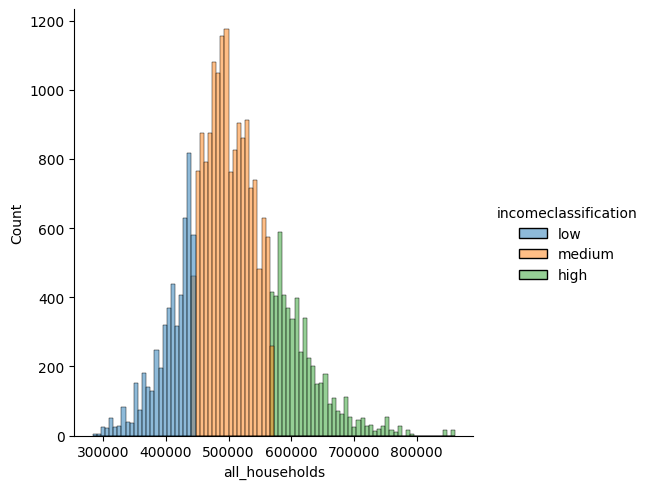

In [33]:
upper = gk_incomes['all_households'].quantile(0.80)
lower = gk_incomes['all_households'].quantile(0.20)
maximum = gk_incomes['all_households'].max()
gk_incomes['incomeclassification'] = pd.cut(gk_incomes.all_households, bins=[0,lower, upper, maximum], labels=['low','medium','high'])

sns.displot(data=gk_incomes, x='all_households', hue='incomeclassification')

In [34]:
gk_households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
gk_households.head()

grunnkrets_id  year  couple_children_0_to_5_years  \
0       12010509  2015                             0   
1       14390206  2015                             0   
2       18040514  2015                            10   
3       18040804  2015                             0   
4       18200101  2015                             0   

   couple_children_18_or_above  couple_children_6_to_17_years  \
0                            0                              4   
1                            7                              0   
2                            0                              0   
3                            0                              0   
4                            6                              0   

   couple_without_children  single_parent_children_0_to_5_years  \
0                        0                                    0   
1                        0                                    0   
2                        0                                    0   
3                        0                                    0   
4                        0                                    0   

   single_parent_children_18_or_above  single_parent_children_6_to_17_years  \
0                                   0                                     0   
1                                   0                                     0   
2                                   0                                     0   
3                                   0                                     0   
4                                   0                                     0   

   singles  
0        4  
1        3  
2        7  
3        0  
4        4

In [35]:
gk_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
gk_ages.head()

grunnkrets_id  year  age_0  age_1  age_2  age_3  age_4  age_5  age_6  \
0       16013117  2015     14     14     14     14     13     13     12   
1       16013117  2016     10     10     10     10     10     10      9   
2       11030206  2015      5      5      5      5      5      4      4   
3       16011203  2016      2      2      2      2      2      3      3   
4        3011601  2016      7      7      7      7      6      6      5   

   age_7  ...  age_81  age_82  age_83  age_84  age_85  age_86  age_87  age_88  \
0     11  ...       0       0       0       0       0       0       0       0   
1      9  ...       0       0       0       0       0       0       0       0   
2      3  ...       0       0       0       0       0       0       0       0   
3      3  ...       1       1       1       1       1       1       1       0   
4      4  ...       1       1       0       0       0       0       0       0   

   age_89  age_90  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0  

[5 rows x 93 columns]

# ___________ _2. Feature Engineering_ ___________

In [81]:
stores_train = pd.read_csv('data/stores_train.csv')
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
gk_incomes = pd.read_csv('data/grunnkrets_income_households.csv')
gk_households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
gk_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
buss_stopps = pd.read_csv('data/busstops_norway.csv')

grunnkrets.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_incomes.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_households.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_ages.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
buss_stopps.drop_duplicates(subset=['busstop_id'], inplace=True)



Grunnkrets

In [82]:
municipality_area = grunnkrets.groupby('municipality_name').area_km2.transform('sum')
grunnkrets['municipality_area'] = municipality_area

grunnkrets.head()

grunnkrets_id  year     grunnkrets_name          district_name  \
0       10010701  2015      Grim-Dueknipen  Grim-Møllevann-Dalane   
1       10010803  2015  Kvadraturen sørøst         Kvadraturen-Eg   
2       10020608  2015            Ormestad                  Holum   
3       10020901  2015              Tregde        Tregde-Skjernøy   
4       10030210  2015           Bryneheia             Vanse/Åpta   

  municipality_name                                           geometry  \
0      Kristiansand  MULTIPOLYGON(((7.97199691121304 58.14336769560...   
1      Kristiansand  POLYGON((8.00234207061135 58.1443514886041, 8....   
2            Mandal  POLYGON((7.48512808482995 58.0374976883392, 7....   
3            Mandal  MULTIPOLYGON(((7.50996051810658 58.02134863868...   
4           Farsund  POLYGON((6.70396719073296 58.0877854965615, 6....   

   area_km2  municipality_area  
0  0.768961          48.018692  
1  0.361355          48.018692  
2  0.280188          17.017158  
3  0.156311          17.017158  
4  0.791894          46.308421

Income

In [83]:
gk_incomes.rename(columns = {'all_households':'income_gk'}, inplace = True)

# income in district
gk_districts = grunnkrets[['grunnkrets_id','district_name']]
gk_incomes = pd.merge(gk_incomes, gk_districts, how='left', on='grunnkrets_id')

income_district = gk_incomes.groupby(['district_name']).income_gk.transform('mean')
gk_incomes['income_district'] = income_district

# Mean revenue in district
gk_revenues = pd.DataFrame(stores_train[['grunnkrets_id','revenue']])
gk_revenues.rename(columns = {'revenue':'revenue_gk'}, inplace = True)
gk_revenues = gk_revenues.groupby('grunnkrets_id').revenue_gk.mean()
gk_incomes = pd.merge(gk_incomes, gk_revenues, how='left', on='grunnkrets_id')
#gk_incomes['revenue_gk'].fillna(0,inplace=True)
gk_incomes['mean_rev_district'] = gk_incomes.groupby(['district_name']).revenue_gk.transform('mean')

# label income in district as low medium high
""" upper = gk_incomes['income_district'].quantile(0.80)
lower = gk_incomes['income_district'].quantile(0.20)
maximum = gk_incomes['income_district'].max()
gk_incomes['income_classification'] = pd.cut(gk_incomes.income_district, bins=[0,lower, upper, maximum], labels=[1,2,3]) """

# label income in gk as low medium high
upper = gk_incomes['income_gk'].quantile(0.80)
lower = gk_incomes['income_gk'].quantile(0.20)
maximum = gk_incomes['income_gk'].max()
gk_incomes['income_classification'] = pd.cut(gk_incomes.income_gk, bins=[0,lower, upper, maximum], labels=['low','medium','high'])


#gk_incomes.head(5)


grunnkrets_id  year  income_gk  singles  couple_without_children  \
0       14200105  2016     551700   270300                        0   
1        2311202  2015     577700   311800                        0   
2        2310501  2015     668800   292500                        0   
3       14200401  2016     507000   250700                        0   
4       14200103  2015     539900   275800                        0   

   couple_with_children  other_households  single_parent_with_children  \
0                     0                 0                            0   
1                682300                 0                            0   
2                842000                 0                            0   
3                     0                 0                            0   
4                710300                 0                            0   

  district_name  income_district  revenue_gk  mean_rev_district  \
0         Norum    542260.000000         NaN                NaN   
1   Gjelleråsen    590433.333333         NaN          25.331667   
2      Leirsund    668800.000000         NaN                NaN   
3      Fjærland    507000.000000         NaN           3.474667   
4         Norum    542260.000000         NaN                NaN   

  income_classification  
0                medium  
1                  high  
2                  high  
3                medium  
4                medium

Ages

In [84]:
# Merge in selected columns
gk_area = grunnkrets[['grunnkrets_id','area_km2','municipality_area','municipality_name','district_name']]
gk_ages = pd.merge(gk_ages, gk_area, how='left', on='grunnkrets_id')

# Number of people features in grunnkrets
tot_people_in_gk = np.sum(gk_ages.iloc[:,np.arange(2,93,1)], axis=1)
gk_ages['tot_people_gk'] = tot_people_in_gk

# Number of people features in municipality
tot_people_in_municipality = gk_ages.groupby('municipality_name').tot_people_gk.transform('sum')
gk_ages['tot_people_municipality'] = tot_people_in_municipality

# Number of people features in district
tot_people_in_district = gk_ages.groupby('district_name').tot_people_gk.transform('sum')
gk_ages['tot_people_district'] = tot_people_in_district

# People density gk
gk_ages['people_density_gk'] = (gk_ages['tot_people_gk'] / gk_ages['area_km2'])
gk_ages['people_density_gk_log'] = np.log1p(gk_ages['tot_people_gk'] / gk_ages['area_km2'])

# People density municipality
gk_ages['people_density_municipality'] = (gk_ages['tot_people_municipality'] / gk_ages['municipality_area'])
gk_ages['people_density_municipality_log'] = np.log1p(gk_ages['tot_people_municipality'] / gk_ages['municipality_area'])

# People density district
district_area_km2 = gk_ages.groupby('municipality_name').area_km2.transform('sum')
gk_ages['district_area_km2'] = district_area_km2

gk_ages['people_density_district'] = (gk_ages['tot_people_district'] / gk_ages['district_area_km2'])
gk_ages['people_density_district_log'] = np.log1p(gk_ages['people_density_district'])




# City name
gk_ages['city'] = "none"
col_idx = gk_ages.columns.get_loc('city')
for mun in gk_ages['municipality_name'].unique():
        gk_ages.iloc[gk_ages[(gk_ages['municipality_name']==mun) & (gk_ages['tot_people_municipality']>100000)].index,[col_idx]] = mun




gk_ages.head(5)



grunnkrets_id  year  age_0  age_1  age_2  age_3  age_4  age_5  age_6  \
0       16013117  2015     14     14     14     14     13     13     12   
1       11030206  2015      5      5      5      5      5      4      4   
2       16011203  2016      2      2      2      2      2      3      3   
3        3011601  2016      7      7      7      7      6      6      5   
4        3010308  2015      7      7      7      7      7      6      6   

   age_7  ...  tot_people_municipality  tot_people_district  \
0     11  ...                   183366                 9305   
1      3  ...                   130547                 4065   
2      3  ...                   183366                 9324   
3      4  ...                   655976                 6261   
4      5  ...                   655976                 5083   

   people_density_gk  people_density_gk_log  people_density_municipality  \
0       13276.775063               9.493847                  1274.839344   
1        6239.892860               8.738879                  2152.071656   
2        9224.102158               9.129684                  1274.839344   
3       18981.134917               9.851254                  4692.839429   
4       13875.630626               9.537961                  4692.839429   

   people_density_municipality_log  district_area_km2  \
0                         7.151360         124.535620   
1                         7.674651          55.864804   
2                         7.151360         124.535620   
3                         8.454006         127.673762   
4                         8.454006         127.673762   

   people_density_district  people_density_district_log       city  
0                74.717579                     4.327010  Trondheim  
1                72.764956                     4.300884  Stavanger  
2                74.870146                     4.329023  Trondheim  
3                49.039050                     3.912804       Oslo  
4                39.812409                     3.708986       Oslo  

[5 rows x 108 columns]

Households

In [85]:
gk_municipalities = grunnkrets[['grunnkrets_id','municipality_name']]

# Number of house holds grunnkrets level
gk_households['nb_households_gk']  = np.sum(gk_households.iloc[:,np.arange(2,10,1)], axis=1)
gk_households['nb_households_gk_log']  = np.log1p(gk_households['nb_households_gk'])

# Number of house holds municipality level
gk_households = pd.merge(gk_households, gk_municipalities, how='left', on='grunnkrets_id')
nb_housholds_municipality = gk_households.groupby('municipality_name').nb_households_gk.transform('sum')
gk_households['nb_households_municipality'] = nb_housholds_municipality
gk_households['nb_households_municipality_log'] = np.log1p(nb_housholds_municipality)


gk_households.head()




grunnkrets_id  year  couple_children_0_to_5_years  \
0       12010509  2015                             0   
1       14390206  2015                             0   
2       18040514  2015                            10   
3       18040804  2015                             0   
4       18200101  2015                             0   

   couple_children_18_or_above  couple_children_6_to_17_years  \
0                            0                              4   
1                            7                              0   
2                            0                              0   
3                            0                              0   
4                            6                              0   

   couple_without_children  single_parent_children_0_to_5_years  \
0                        0                                    0   
1                        0                                    0   
2                        0                                    0   
3                        0                                    0   
4                        0                                    0   

   single_parent_children_18_or_above  single_parent_children_6_to_17_years  \
0                                   0                                     0   
1                                   0                                     0   
2                                   0                                     0   
3                                   0                                     0   
4                                   0                                     0   

   singles  nb_households_gk  nb_households_gk_log municipality_name  \
0        4                 8              2.197225            Bergen   
1        3                10              2.397895            Vågsøy   
2        7                17              2.890372              Bodø   
3        0                 0              0.000000              Bodø   
4        4                10              2.397895         Alstahaug   

   nb_households_municipality  nb_households_municipality_log  
0                      275894                       12.527776  
1                        5753                        8.657651  
2                       48360                       10.786449  
3                       48360                       10.786449  
4                        7075                        8.864464

Buss stops

In [86]:
# Number of buss stops

def add_latlong(buss):
    buss['lat'] = 0.0
    buss['lon'] = 0.0
    lonList = []
    latList = [] 
    for index, row in buss.iterrows():
        lon = row['geometry']
        lon = lon[6:]
        lon = lon.replace(')','')
        
        lat = lon.split()[1]
        lon = lon.split()[0]
        lon = float(lon)
        lat = float(lat) 

        lonList.append(lon)
        latList.append(lat)
        
    buss['lon'] = np.array(lonList)
    buss['lat'] = np.array(latList)

def euclidian_dist(X, Y):
    sx = np.sum(X**2, keepdims=True)
    sy = np.sum(Y**2, axis=1, keepdims=True)
    return np.sqrt(-2 * X.dot(Y.T) + sx + sy.T)

def busstop_distances(store, bus):
    print("Calculating busstops")
    busMat = bus[['lat', 'lon']]
    busMat = busMat.to_numpy()

    storeMat = store[['lat', 'lon']]
    storeMat = storeMat.to_numpy()

    mins = []
    withinx = []
    withiny = []
    withinz = []
    for row in storeMat:
        res = euclidian_dist(row, busMat)

        res = res.flatten()
        mins.append(min(res))
        withinx.append(len(res[res<0.1]))
        withiny.append(len(res[res<0.05]))
        withinz.append(len(res[res<0.005]))
    
    store['closestBusStop'] = np.array(mins)
    store['busStopsWithinXkm'] = np.array(withinx)
    store['busStopsWithinYkm'] = np.array(withiny)
    store['busStopsWithinZKm'] = np.array(withinz)


In [87]:
add_latlong(buss_stopps)

In [88]:
def add_busstops(stores):
    busstop_distances(stores, buss_stopps)

Store set

In [89]:
def self_aggregate_columns (stores):
    # has mall ~ dropped "has_mall" as it had low impact seen in feature engineering plots
    #stores['mall_name'] = stores['mall_name'].fillna('0')
    #stores['has_mall'] = stores['mall_name'].apply(lambda x: 1 if x !='0' else 0)


    # has chain
    stores['chain_name'] = stores['chain_name'].fillna('0')
    stores['has_chain'] = stores['chain_name'].apply(lambda x: 1 if x !='0' else 0)


    # Distance to another store


    # Distance to another store of same type


    # Number of similar stores in municipality
    gk_municipalities = grunnkrets[['grunnkrets_id','municipality_name']]
    stores = pd.merge(stores, gk_municipalities, how='left', on='grunnkrets_id')
    
    nb_similar_stores_municipality = stores.groupby(['municipality_name','plaace_hierarchy_id']).plaace_hierarchy_id.transform('count')
    stores['nb_similar_stores_municipality'] = nb_similar_stores_municipality
    
    
    # Encoded plaace_hierarchy_id # completely unneccesary
    #le = LabelEncoder()
    #stores['transformed_p_id'] = le.fit_transform(stores['plaace_hierarchy_id'])
    

    # lat lon log transform ~ dropped as it had little effect
    #stores['lat_log'] = np.log1p(stores['lat'])
    #stores['lon_log'] = np.log1p(stores['lon'])
    
    

     
    
    remove_columns(stores,['municipality_name'])# revert action, gets added later
    return stores

Concat columns

In [265]:
def add_selected_columns(df, include_bad_columns=False):
    df = self_aggregate_columns(df)
    add_busstops(df)
    gk = grunnkrets[['grunnkrets_id','municipality_name', 'district_name']]
    gk_i = gk_incomes[['grunnkrets_id','income_gk','income_classification','income_district','mean_rev_district']]
    gk_h = gk_households[['grunnkrets_id','nb_households_gk','nb_households_municipality','nb_households_gk_log','nb_households_municipality_log']]
    gk_a = gk_ages[['grunnkrets_id','tot_people_gk','tot_people_district','tot_people_municipality','people_density_gk_log','people_density_municipality_log','people_density_gk','people_density_municipality','city','people_density_district','people_density_district_log']]
    
    concat = pd.merge(df, gk, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_i, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_h, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_a, how='left', on='grunnkrets_id')
    
    # NaN handling
    concat['municipality_name'].fillna('0', inplace=True)
    concat['income_classification'].fillna('medium', inplace=True)
    concat['nb_similar_stores_municipality'].fillna(0, inplace=True)
    concat['income_gk'].fillna(450000, inplace=True)
    #concat['mall_name'].fillna('0', inplace=True)
    concat['city'].fillna('none', inplace=True)
    concat['people_density_district'].fillna(180.0, inplace=True)#the mean value
    concat['people_density_district_log'].fillna(4.637, inplace=True)        
    concat['district_name'].fillna('none', inplace=True)
    #concat['mall_name'].fillna('none', inplace=True)
    concat['income_district'].fillna(466285.26671004744, inplace=True) #replace with mean value
    concat['mean_rev_district'].fillna(8.20564984134999, inplace=True) #replace with mean value

    # Remove columns that dont contribute positively to the result
    if not include_bad_columns:
        remove_columns(concat, [
                                #'sales_channel_name',
                                #'grunnkrets_id',
                                #'lat',
                                #'lon',
                                #'chain_name',
                                #'mall_name',
                                #'has_chain',
                                #'municipality_name',
                                'district_name',
                                #'income_gk',
                                'income_district',
                                'mean_rev_district',
                                #'income_classification',
                                'nb_similar_stores_municipality',
                                #'nb_households_gk',
                                #'nb_households_gk_log',
                                #'nb_households_municipality',
                                #'nb_households_municipality_log',
                                #'tot_people_gk',
                                'tot_people_district',
                                #'tot_people_municipality',
                                'people_density_gk',
                                #'people_density_gk_log',
                                'people_density_municipality',
                                #'people_density_municipality_log',
                                'busStopsWithinXkm',
                                #'busStopsWithinYkm',
                                'busStopsWithinZKm',
                                'city',
                                'people_density_district',
                                'people_density_district_log'
                                ])
    
    
    return concat
""" plaace_hierarchy_id                  object
sales_channel_name                   object
grunnkrets_id                         int64
lat                                 float64
lon                                 float64
chain_name                           object
mall_name                            object
has_chain                             int64
municipality_name                    object
income_gk                           float64
income_classification              category
nb_households_gk                    float64
nb_households_gk_log                float64
nb_households_municipality          float64
nb_households_municipality_log      float64
tot_people_gk                       float64
people_density_gk_log               float64
tot_people_municipality             float64
people_density_municipality_log     float6 """

' plaace_hierarchy_id                  object\nsales_channel_name                   object\ngrunnkrets_id                         int64\nlat                                 float64\nlon                                 float64\nchain_name                           object\nmall_name                            object\nhas_chain                             int64\nmunicipality_name                    object\nincome_gk                           float64\nincome_classification              category\nnb_households_gk                    float64\nnb_households_gk_log                float64\nnb_households_municipality          float64\nnb_households_municipality_log      float64\ntot_people_gk                       float64\npeople_density_gk_log               float64\ntot_people_municipality             float64\npeople_density_municipality_log     float6 '

Calculating busstops


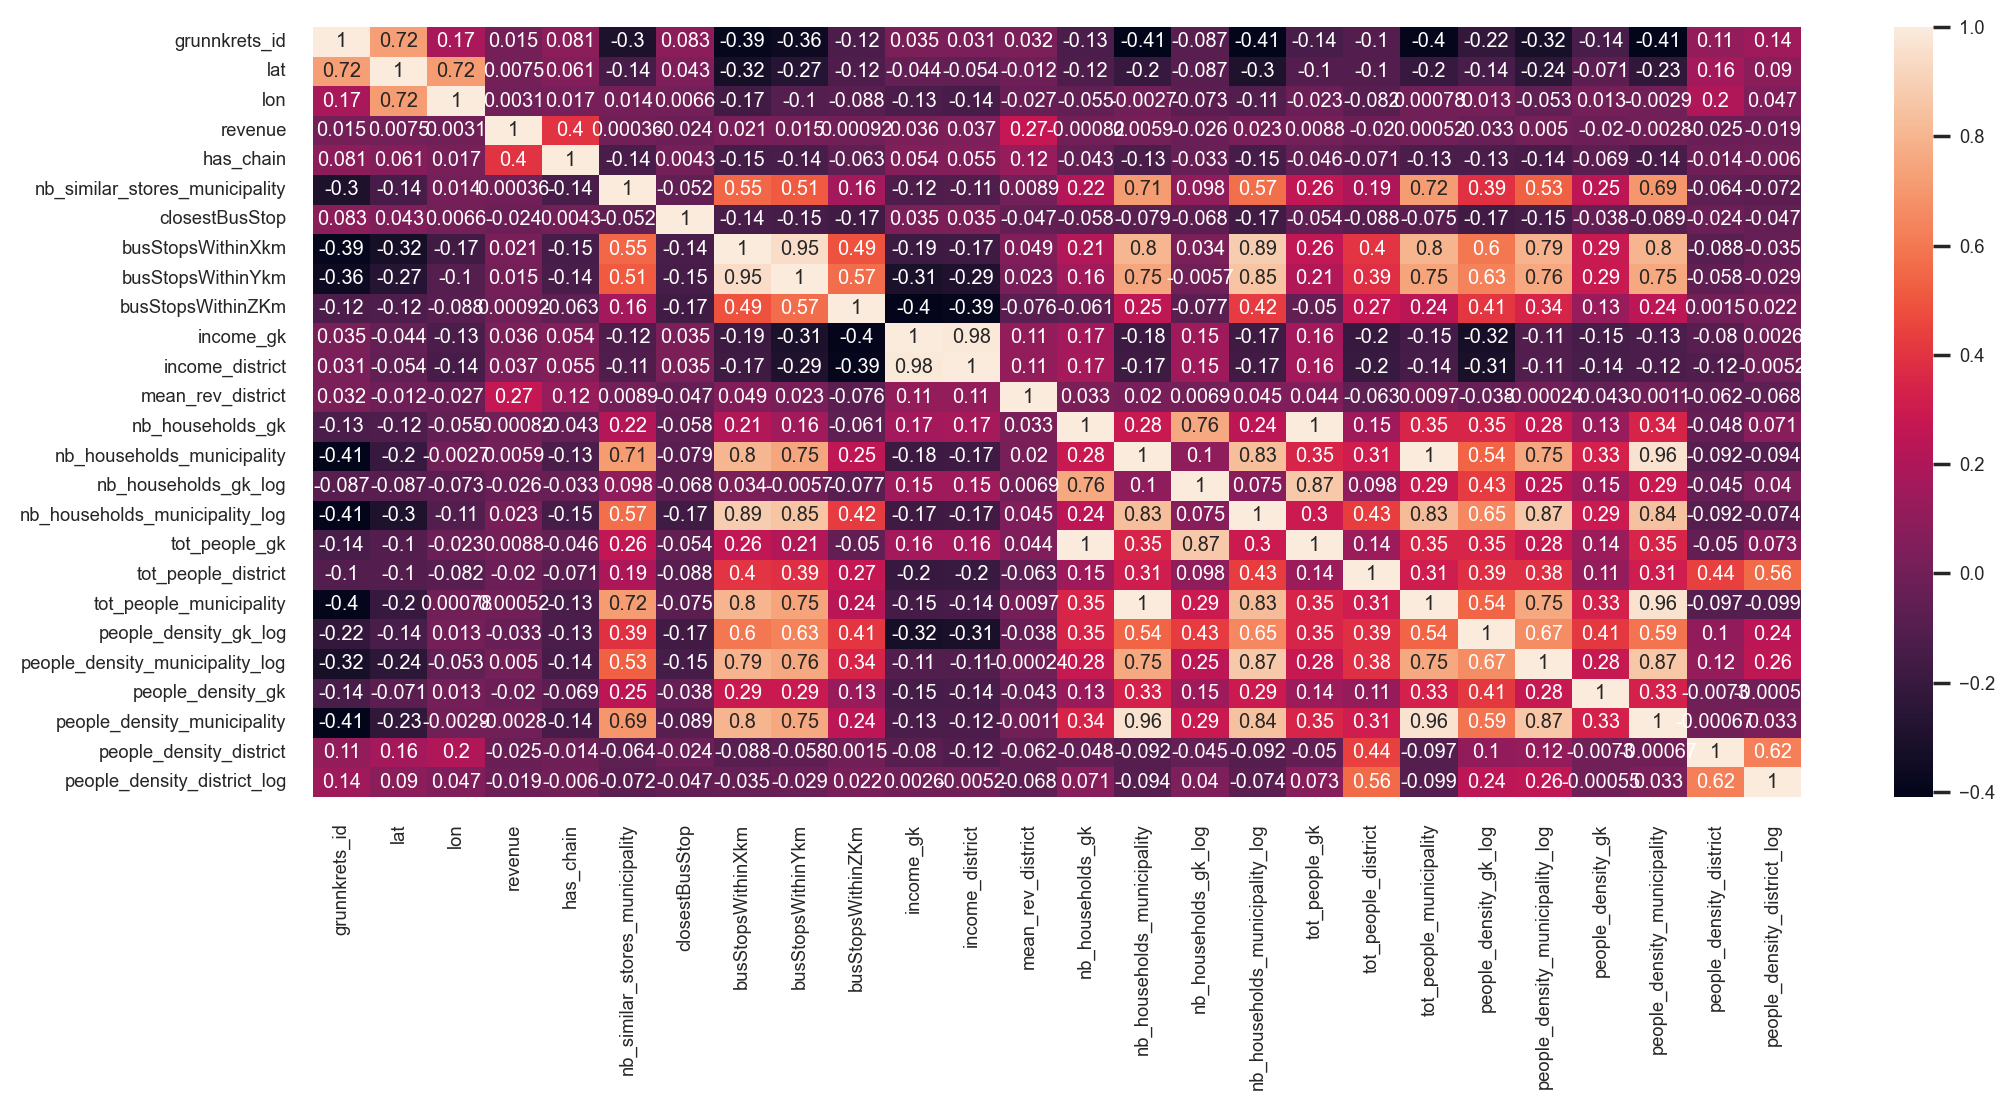

In [233]:
stores_train = pd.read_csv('data/stores_train.csv')
remove_columns(stores_train, ['store_id','store_name','year','address'])
stores_train = add_selected_columns(stores_train, include_bad_columns=True) # includes the bad columns so we can demonstrate that they are actually bad

sns.set(font_scale=0.6)
plt.figure(figsize=(12,5), dpi=200)
sns.heatmap(stores_train.corr(), annot=True)
plt.show()

In [234]:
print(stores_train.isnull().sum())
#print(stores_train.dtypes)
#stores_train.iloc[:,[1,8,9,10,11,12,16,23,24,25]].head()
#plt.figure(figsize=(12,5), dpi=200)
#sns.pairplot(stores_train)
#plt.show()


plaace_hierarchy_id                    0
sales_channel_name                     0
grunnkrets_id                          0
lat                                    0
lon                                    0
chain_name                             0
mall_name                          10579
revenue                                0
has_chain                              0
nb_similar_stores_municipality         0
closestBusStop                         0
busStopsWithinXkm                      0
busStopsWithinYkm                      0
busStopsWithinZKm                      0
municipality_name                      0
district_name                          0
income_gk                              0
income_classification                  0
income_district                        0
mean_rev_district                      0
nb_households_gk                     124
nb_households_municipality           124
nb_households_gk_log                 124
nb_households_municipality_log       124
tot_people_gk   

We can see a lot from the plot above:
- people_density_municipality vs reveneue - the distribution is very uneven and somewhat discretely distributed - Remove
- people_density_gk vs reveneue - the distribution is terrible here as well - Remove
- people_density_municipality_log vs revenue - the distribution is much more even - Include
- people_density_gk_log vs revenue - the distribution is much more even - Include
- tot_people_municipality vs revenue - very discretely distributed for the biggest municipalities - unsure whether to remove or not
- tot_people_gk vs revenue - more evenly distributed than municipalities - include
- nb_household_municipality vs revenue - very discretely distributed for the biggest municipalities - unsure whether to remove or not
- nb_households_gk vs revenue - more evenly distributed than municipalities - include
- nb_household_municipality_log vs revenue - seems more evenely distributed than not logtransformed - unsure whether to remove or not
- nb_households_gk_log vs revenue - more evenly distributed than municipalities_log - include
- nb_similar_stores_municipality - somewhat unevenly distributed - unsure whether to remove or not



# ___________ _3. Machine Learning Models and Predictions_ ___________


### Helper functions

In [48]:
def convert_DType_LGBM(dFrame):
    le = LabelEncoder()
    X = pd.DataFrame()
    
    for col_name in dFrame:
        if dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
            
        #elif col_name == 'grunnkrets_id':
        #    X[col_name] = le.fit_transform(dFrame[col_name])
        
        else:
            X[col_name] = dFrame[col_name]
    
    return X

In [106]:
def convert_DType_CatBoost(dFrame):
    X = pd.DataFrame()
    for col_name in dFrame:
        
        if col_name == 'grunnkrets_id':
            X[col_name] = dFrame[col_name]#.astype('category')
        
        elif col_name == 'mall_name':
            X[col_name] = dFrame[col_name].astype(str)
        
        #elif col_name == 'income_classification':
        #    X[col_name] = dFrame[col_name].astype('category')

        elif dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
            
        else:
            X[col_name] = dFrame[col_name]
    
    return X


In [166]:
def convert_DType_XGBoost(dFrame):
    X = pd.DataFrame()
    le = LabelEncoder()
    for col_name in dFrame:
        
        if col_name =='income_classification':
            X[col_name] = le.fit_transform(dFrame[col_name])
            
        elif dFrame[col_name].dtypes != 'object':
            X[col_name] = dFrame[col_name]
            

    
    return X

Load train data and divide into test and train

In [121]:
def get_data(test_size=0.20):
    stores_train = pd.read_csv('data/stores_train.csv')
    stores_test = pd.read_csv('data/stores_test.csv')

    # select prefered columns
    remove_columns(stores_train, ['store_id','store_name','year','address'])
    remove_columns( stores_test, ['store_id','store_name','year','address'])

    # Add features
    stores_train = add_selected_columns(stores_train)
    stores_test = add_selected_columns(stores_test)

    # Preprocess/Clean data
    #quantile_storeType_vs_revenue(stores_train,0.01, 0.88)

    # Divide data into train and test set
    x_train = stores_train.drop('revenue', axis=1)

    y_train = stores_train['revenue']
    y_train=np.log1p(y_train) #log transform revenue

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=3)
    
    return  x_train, x_test, y_train, y_test, stores_test


In [122]:
#x_train_check, _, _, _, _ = get_data()
#print(x_train_check.dtypes)
#print(x_train_check.isnull().sum())

#### Load data

In [235]:
x_train, x_test, y_train, y_test, test = get_data()

Calculating busstops
Calculating busstops


#### LightGBM


In [236]:
# Load data
LGBM_x_train, LGBM_x_test, y_train, y_test = x_train, x_test, y_train, y_test

# Convert to approperiate dtypes
LGBM_x_train = convert_DType_LGBM(LGBM_x_train)
LGBM_x_test = convert_DType_LGBM(LGBM_x_test)

# Make model, fit and predict
# Params obtained trough verstack optimization in the model interpretation part and reading up on this guide: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
LGBM_parameters = {'learning_rate': 0.02, 'num_leaves': 97, 'colsample_bytree': 0.9688856109245801, 'subsample': 0.7477123270599539, 'verbosity': -1, 'random_state': 42, 'objective': 'regression', 'metric': 'l2', 'num_threads': 6, 'reg_alpha': 5.385247020124032e-05, 'min_sum_hessian_in_leaf': 0.010643779743657742, 'reg_lambda': 0.15532905568072503, 'n_estimators': 166}
#LGBM_parameters = {}
    
LGBM_model = LGBMRegressor(**LGBM_parameters)
LGBM_model.fit(LGBM_x_train, y_train)
LGBM_pred = LGBM_model.predict(LGBM_x_test)
LGBM_pred=np.expm1(LGBM_pred) #invert log transform

# Run some tests
print(f"rmsle: {rmsle(y_test,LGBM_pred)}")

rmsle: 0.8850330347239564


In [ ]:
# Previous rmse scores gave the following kaggle scores:
# - 0.9055645241057166 rmsle resulted in: 0.71576 on kaggle - LGBM a lot of columns)

#### Catboost

In [280]:
# Load data
CB_x_train, CB_x_test, y_train, y_test = x_train, x_test, y_train, y_test

# Convert to approperiate dtypes
CB_x_train = convert_DType_CatBoost(CB_x_train)
CB_x_test = convert_DType_CatBoost(CB_x_test)
categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category'))[0]
print(categorical_features_indices)
print(CB_x_train.dtypes)
test_pool = cb.Pool(CB_x_test, y_test, categorical_features_indices )

# Make model, fit and predict
# params found with gridsearch in the model interpretation part and some testing on our own
CB_parameters = {'random_state' : 32, 'depth' : 8, 'learning_rate' : 0.005}
#CB_parameters = {}

CB_model = cb.CatBoostRegressor(loss_function='RMSE', **CB_parameters, verbose=0)
CB_model.fit( CB_x_train, y_train, cat_features=categorical_features_indices, eval_set=test_pool, use_best_model=True, plot=False)
CB_pred = CB_model.predict(CB_x_test)
CB_pred = np.expm1(CB_pred)


# Run some tests
print(f"rmsle: {rmsle(y_test,CB_pred)}")


[ 0  1  5  6 10 12]
plaace_hierarchy_id                category
sales_channel_name                 category
grunnkrets_id                         int64
lat                                 float64
lon                                 float64
chain_name                         category
mall_name                            object
has_chain                             int64
closestBusStop                      float64
busStopsWithinYkm                     int64
municipality_name                  category
income_gk                           float64
income_classification              category
nb_households_gk                    float64
nb_households_municipality          float64
nb_households_gk_log                float64
nb_households_municipality_log      float64
tot_people_gk                       float64
tot_people_municipality             float64
people_density_gk_log               float64
people_density_municipality_log     float64
dtype: object
rmsle: 0.8628857961914211


#### XGBoost

In [261]:

# Load data
XG_x_train, XG_x_test, y_train, y_test = x_train, x_test, y_train, y_test

# Convert to approperiate dtypes
XG_x_train = convert_DType_XGBoost(XG_x_train)
XG_x_test = convert_DType_XGBoost(XG_x_test)
#categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category'))[0]
#print(categorical_features_indices)
print(XG_x_train.dtypes)
#test_pool = cb.Pool(CB_x_test, y_test, categorical_features_indices )

# Make model, fit and predict
XG_parameters = {}

XG_model = xg.XGBRegressor(**XG_parameters)#, enable_categorical=True, tree_method="gpu_hist")
XG_model.fit(XG_x_train,y_train)
XG_pred = XG_model.predict(XG_x_test)
XG_pred = np.expm1(XG_pred)


# Run some tests
number_of_negatives = 0
for i in range(len(XG_pred)):
    if XG_pred[i] < 0.0:
        number_of_negatives += 1
        XG_pred[i] = 0.0

print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test,XG_pred)}")

grunnkrets_id                        int64
lat                                float64
lon                                float64
has_chain                            int64
closestBusStop                     float64
busStopsWithinXkm                    int64
busStopsWithinYkm                    int64
income_gk                          float64
income_classification                int64
nb_households_gk                   float64
nb_households_municipality         float64
nb_households_gk_log               float64
nb_households_municipality_log     float64
tot_people_gk                      float64
tot_people_municipality            float64
people_density_gk_log              float64
people_density_municipality_log    float64
dtype: object
number of negatives: 1
rmsle: 0.9089864342974378


#### Compare models

In [263]:
compare_preds = pd.DataFrame()
compare_preds['true'] = y_test
compare_preds['median'] = np.median([CB_pred,LGBM_pred,XG_pred],axis=0)
compare_preds['Median err'] = np.abs(np.median([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test)
compare_preds['catboost'] = CB_pred
compare_preds['lightgbm'] = LGBM_pred
compare_preds['XGBoost'] = XG_pred
compare_preds['CB err'] = np.abs(CB_pred - y_test)
compare_preds['LGBM err'] = np.abs(LGBM_pred - y_test)
compare_preds['XG err'] = np.abs(XG_pred - y_test)
compare_preds['Mean err'] = np.abs((CB_pred+LGBM_pred+XG_pred)/3 - y_test)

 
print(f" Sum Err Mean:   {np.sum(compare_preds['Mean err'])}")
print(f" Sum Err Median: {np.sum(compare_preds['Median err'])}")
print(f" Sum Err CB:     {np.sum(compare_preds['CB err'])}")
print(f" Sum Err LGBM:   {np.sum(compare_preds['LGBM err'])}")
print(f" Sum Err XG :    {np.sum(compare_preds['XG err'])}")

print(f" Mean Err Mean:   {np.mean(compare_preds['Mean err'])}")
print(f" Mean Err Median: {np.mean(compare_preds['Median err'])}")
print(f" Mean Err CB:     {np.mean(compare_preds['CB err'])}")
print(f" Mean Err LGBM:   {np.mean(compare_preds['LGBM err'])}")
print(f" Mean Err XG:     {np.mean(compare_preds['XG err'])}")

print(f" RSMLE mean:      {rmsle(y_test, ((CB_pred + LGBM_pred + XG_pred)/3))}")
print(f" RSMLE Median:    {rmsle(y_test, np.median([CB_pred,LGBM_pred,XG_pred],axis=0))}")
print(f" RSMLE LGBM:      {rmsle(y_test, LGBM_pred)}")
print(f" RSMLE CB:        {rmsle(y_test, CB_pred)}")
print(f" RSMLE XG:        {rmsle(y_test, XG_pred)}")

print(f" \n Combos")
print(f" RSMLE CB & LGBM:    {rmsle(y_test, ((CB_pred + LGBM_pred)/2))}")
print(f" RSMLE CB & XG:      {rmsle(y_test, ((CB_pred + XG_pred)/2))}")
print(f" RSMLE XG & LGBM:    {rmsle(y_test, ((LGBM_pred + XG_pred)/2))}")
print(f" RSMLE Mean:         {rmsle(y_test, ((CB_pred + LGBM_pred + XG_pred)/3))}")
print(f" RSMLE Median:       {rmsle(y_test, np.median([CB_pred,LGBM_pred,XG_pred],axis=0))}")
print()
print(f" Sum Err CB & LGBM:  {np.sum(np.abs((CB_pred+LGBM_pred)/2 - y_test))}")
print(f" Sum Err CB & XG:    {np.sum(np.abs((CB_pred+XG_pred)/2 - y_test))}")
print(f" Sum Err XG & LGBM:  {np.sum(np.abs((LGBM_pred+XG_pred)/2 - y_test))}")
print(f" Sum Err Mean:       {np.sum(np.abs((CB_pred+LGBM_pred+XG_pred)/3 - y_test))}")
print(f" Sum Err Median:     {np.sum(np.abs(np.median([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test))}")
print()
print(f" Mean Err CB & LGBM: {np.mean(np.abs((CB_pred+LGBM_pred)/2 - y_test))}")
print(f" Mean Err CB & XG:   {np.mean(np.abs((CB_pred+XG_pred)/2 - y_test))}")
print(f" Mean Err XG & LGBM: {np.mean(np.abs((LGBM_pred+XG_pred)/2 - y_test))}")
print(f" Mean Err mean:      {np.mean(np.abs((CB_pred+LGBM_pred+XG_pred)/3 - y_test))}")
print(f" Mean Err Median:    {np.mean(np.abs(np.median([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test))}")


compare_preds.head(50)

 Sum Err Mean:   9939.091522100705
 Sum Err Median: 9679.435507530134
 Sum Err CB:     10087.988971650482
 Sum Err LGBM:   10916.382702955045
 Sum Err XG :    9103.864700357275
 Mean Err Mean:   3.864343515591254
 Mean Err Median: 3.7633886110148267
 Mean Err CB:     3.9222352144830803
 Mean Err LGBM:   4.244316758536176
 Mean Err XG:     3.539605248972502
 RSMLE mean:      0.8869463652085241
 RSMLE Median:    0.8508467895111793
 RSMLE LGBM:      0.8850330347239564
 RSMLE CB:        0.8669602627038567
 RSMLE XG:        0.9089864342974378
 
 Combos
 RSMLE CB & LGBM:    0.8759251292046014
 RSMLE CB & XG:      0.8871198136057359
 RSMLE XG & LGBM:    0.8980734974082208
 RSMLE Mean:         0.8869463652085241
 RSMLE Median:       0.8508467895111793

 Sum Err CB & LGBM:  10486.426425107089
 Sum Err CB & XG:    9487.750581278373
 Sum Err XG & LGBM:  9912.211606562058
 Sum Err Mean:       9939.091522100705
 Sum Err Median:     9679.435507530134

 Mean Err CB & LGBM: 4.077148687833239
 Mean Err

true     median  Median err   catboost   lightgbm    XGBoost  \
4885   2.518100   2.889030    0.370930   2.889030   3.427659   2.373996   
8164   1.584940   1.776485    0.191545   1.669847   1.776485   3.358894   
5663   1.058137   3.161161    2.103024   2.781871   3.161161  11.904452   
8287   2.036012   2.517760    0.481748   2.517760   2.399789   3.301307   
10650  1.321756   1.291276    0.030480   1.291276   1.195640   3.669620   
9979   1.886615   6.447061    4.560446   6.447061   5.120674   9.290495   
6687   1.138474   2.793992    1.655518   2.844597   2.793992   2.333477   
3919   2.286456  17.066282   14.779826  17.066282  28.920516  13.202650   
6222   1.344951   4.308409    2.963458   4.308409   3.138900   7.124256   
12567  1.159707   1.889753    0.730046   1.871230   1.889753   2.362153   
1878   1.448330   2.028750    0.580420   1.969907   2.028750   2.646038   
3156   2.778943   6.772824    3.993880   6.772824   6.089071  14.258657   
12449  1.135908   2.180492    1.044584   1.722397   2.180492   2.558146   
10925  0.653366   1.267920    0.614554   1.216845   1.267920   3.099622   
3391   2.537894   5.002733    2.464838   5.002733   6.084305   2.963733   
11995  1.776307   5.244866    3.468559   5.244866   3.654345  16.394817   
337    0.000000   4.161984    4.161984   4.161984   2.414325   6.063504   
536    2.534094   3.869507    1.335414   3.869507   3.798707   4.761168   
12461  2.370804   4.914352    2.543548   8.652298   3.846336   4.914352   
10097  1.471325   3.695631    2.224306   3.695631   3.585498   8.489428   
8548   2.837615   3.691602    0.853986   4.269334   3.691602   1.511983   
1172   2.867615   3.833157    0.965543   3.833157   4.238738   0.578098   
552    1.743619   3.142447    1.398828   3.142447   4.484876   2.186028   
243    1.365326   2.596168    1.230842   3.200628   2.596168   1.993739   
4852   1.658419   2.854431    1.196013   2.854431   2.821202   3.658007   
2278   0.934916   2.493395    1.558479   2.782850   2.493395   2.364515   
7426   4.755433  45.253314   40.497881  45.253314  51.885314   8.257315   
221    1.805498   3.543810    1.738312   3.679662   3.543810   2.327171   
5566   0.000000   3.189765    3.189765   3.189765   1.862621   3.652589   
10194  1.214319   1.285053    0.070734   1.662474   1.285053   1.017604   
11492  0.915490   1.498119    0.582628   1.498119   1.452631   2.473790   
12559  1.332894   2.340670    1.007777   1.875806   2.340670   5.522754   
12070  1.811235   2.369614    0.558379   3.629315   2.369614   2.073042   
7335   1.668650   2.176885    0.508236   2.547500   2.176885   1.287561   
7503   4.169467  50.473136   46.303668  50.473136  61.050179  21.456383   
11993  0.484276   2.828231    2.343954   2.828231   2.223254   4.627718   
6065   2.829678  12.294609    9.464931  12.923328  12.294609  10.253974   
8617   3.048514   4.165192    1.116678   4.165192   4.732267   3.894153   
9096   2.268511  11.210790    8.942279  11.562866  11.210790   7.343741   
3412   4.470644  14.159992    9.689348  16.841081  14.159992   6.837177   
9382   1.523226   4.286816    2.763590   4.286816   3.606477  17.658966   
2286   0.638691   1.799489    1.160798   2.111617   1.799489   0.751348   
4477   1.580009   3.740421    2.160412   6.154976   3.364132   3.740421   
12143  1.345993   2.894508    1.548515   2.936983   2.894508   2.478312   
5303   0.909870   3.458994    2.549124   3.900776   3.458994   2.350740   
2639   1.382035   3.813905    2.431870   3.813905   2.952066   9.520310   
3883   1.990884   6.166235    4.175352   6.166235   4.965992   8.767831   
12787  2.172476   3.822005    1.649529   3.822005   3.807216   7.344386   
7285   1.999722   2.601905    0.602183   2.989212   2.601905   1.216883   
5054   0.782531   2.895123    2.112593   2.895123   2.946675   2.593086   

          CB err   LGBM err     XG err   Mean err  
4885    0.370930   0.909560   0.144104   0.378795  
8164    0.084906   0.191545   1.773953   0.683468  
5663    1.723733   2.103024  

## Predict test and submit

In [271]:
# Load data
x_train, x_test, y_train, y_test, test = get_data(test_size=0.1)

print(x_train.columns)

# Convert to approperiate dtypes
LGBM_x_train = convert_DType_LGBM(x_train)
LGBM_test = convert_DType_LGBM(test)

CB_x_train = convert_DType_CatBoost(x_train)
CB_x_test = convert_DType_CatBoost(x_test)
CB_test = convert_DType_CatBoost(test)
categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category') )[0]
test_pool = cb.Pool(CB_x_test, y_test, categorical_features_indices )

XG_x_train = convert_DType_XGBoost(x_train)
XG_test = convert_DType_XGBoost(test)

# Confirm correct feats
print(f"LGBM:\n{LGBM_x_train.dtypes}\n")
print(f"CB:\n{categorical_features_indices}\n{CB_x_train.dtypes}\n")
print(f"XG:\n{XG_x_train.dtypes}\n")

# LGBM
LGBM_model = LGBMRegressor(**LGBM_parameters)
LGBM_model.fit(LGBM_x_train, y_train)
LGBM_pred = LGBM_model.predict(LGBM_test)
LGBM_pred=np.expm1(LGBM_pred) #invert log transform

# Catboost
CB_model = cb.CatBoostRegressor(loss_function='RMSE', **CB_parameters, silent=True)
CB_model.fit(CB_x_train,y_train, cat_features=categorical_features_indices, eval_set=test_pool, use_best_model=True)
CB_pred = CB_model.predict(CB_test)
CB_pred = np.expm1(CB_pred)

# XGBoost
XG_model = xg.XGBRegressor(**XG_parameters)
XG_model.fit(XG_x_train,y_train)
XG_pred = XG_model.predict(XG_test)
XG_pred = np.expm1(XG_pred)

# Aggregate result
PREDICTION = np.median([CB_pred, LGBM_pred, XG_pred],axis=0)#(CB_pred + LGBM_pred)/2

Calculating busstops
Calculating busstops
Index(['plaace_hierarchy_id', 'sales_channel_name', 'grunnkrets_id', 'lat',
       'lon', 'chain_name', 'mall_name', 'has_chain', 'closestBusStop',
       'busStopsWithinYkm', 'municipality_name', 'income_gk',
       'income_classification', 'nb_households_gk',
       'nb_households_municipality', 'nb_households_gk_log',
       'nb_households_municipality_log', 'tot_people_gk',
       'tot_people_municipality', 'people_density_gk_log',
       'people_density_municipality_log'],
      dtype='object')
LGBM:
plaace_hierarchy_id                category
sales_channel_name                 category
grunnkrets_id                         int64
lat                                 float64
lon                                 float64
chain_name                         category
mall_name                          category
has_chain                             int64
closestBusStop                      float64
busStopsWithinYkm                     int64
municip

In [270]:
stores_test = pd.read_csv('data/stores_test.csv')
#write the predicition to file
writeResultToFile(stores_test, PREDICTION, "tripleMedian")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/tripleMedian.csv')
submissionVery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8577 entries, 0 to 8576
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         8577 non-null   object 
 1   predicted  8577 non-null   float64
dtypes: float64(1), object(1)
memory usage: 134.1+ KB


### Models we discarded

#### Random Forest Regressor 

Random Forest Regressor is a model we expirimented with in the beginning but stopped developing as we saw much better results with catboost and lightgbm, the code below i commented out as it is unneccesary to run, but kept in the notebook to show how the project has evolved.

Load, preprocess and convert data to correct format

In [59]:
""" # Load training and test data
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

# Preprocess/Clean data
remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
remove_columns(stores_test, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
#remove_retailers_with_0_revenue(stores_train)
quantile_storeType_vs_revenue(stores_train,0.10, 0.80)

# Divide data into x and y train
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']
x_test = stores_test.copy()

# Convert from object type to numerical
#train set
cat_columns = x_train.select_dtypes(['object']).columns
x_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])
#test set
cat_columns = x_test.select_dtypes(['object']).columns
x_test[cat_columns] = x_test[cat_columns].apply(lambda x: pd.factorize(x)[0])

 """

" # Load training and test data\nstores_train = pd.read_csv('data/stores_train.csv')\nstores_test = pd.read_csv('data/stores_test.csv')\n\n# Preprocess/Clean data\nremove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])\nremove_columns(stores_test, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])\n#remove_retailers_with_0_revenue(stores_train)\nquantile_storeType_vs_revenue(stores_train,0.10, 0.80)\n\n# Divide data into x and y train\nx_train = stores_train.drop('revenue', axis=1)\ny_train = stores_train['revenue']\nx_test = stores_test.copy()\n\n# Convert from object type to numerical\n#train set\ncat_columns = x_train.select_dtypes(['object']).columns\nx_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])\n#test set\ncat_columns = x_test.select_dtypes(['object']).columns\nx_test[cat_columns] = x_test[cat_columns].apply(lambda x: pd.factorize(x)[0])\n\n "

In [60]:
""" stores_train.head() """

' stores_train.head() '

Train model

In [61]:
""" # Model
RFR = RandomForestRegressor(n_estimators=100)

# Fitting
RFR.fit(x_train, y_train) """


' # Model\nRFR = RandomForestRegressor(n_estimators=100)\n\n# Fitting\nRFR.fit(x_train, y_train) '

Test RFR model

In [62]:
""" # predicting the training data set as a pin pointer
pred_train_RFR = RFR.predict(x_train)
print(rmsle(y_train, pred_train_RFR))
print(RFR.score(x_train, y_train)) """

' # predicting the training data set as a pin pointer\npred_train_RFR = RFR.predict(x_train)\nprint(rmsle(y_train, pred_train_RFR))\nprint(RFR.score(x_train, y_train)) '

Predict test and submit

In [63]:
""" pred_test_RFR = RFR.predict(x_test) """

' pred_test_RFR = RFR.predict(x_test) '

In [64]:
""" # Write to file
#writeResultToFile(stores_test, pred_test_RFR, "RFR_10_80_percentile")

# Verify format of submission file
#submissionVery = pd.read_csv('submissionFiles/RFR_10_80_percentile.csv')
#submissionVery.info() """

' # Write to file\n#writeResultToFile(stores_test, pred_test_RFR, "RFR_10_80_percentile")\n\n# Verify format of submission file\n#submissionVery = pd.read_csv(\'submissionFiles/RFR_10_80_percentile.csv\')\n#submissionVery.info() '

# 4. Model Interpretations

## Parameter search

#### Lightgbm

In [286]:
#x_train, x_test, y_train, y_test, _ = get_data()
#LGBM_x_train = convert_DType_LGBM(x_train)
cat_columns = LGBM_x_train.select_dtypes(['category']).columns
LGBM_x_train[cat_columns] = LGBM_x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])

sns.set(font_scale=1)
tuner = LGBMTuner(metric = 'rmsle', verbosity=0);
tuner.fit(LGBM_x_train, y_train);



" #x_train, x_test, y_train, y_test, _ = get_data()\n#LGBM_x_train = convert_DType_LGBM(x_train)\ncat_columns = LGBM_x_train.select_dtypes(['category']).columns\nLGBM_x_train[cat_columns] = LGBM_x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])\n\n# Tune\nsns.set(font_scale=1)\ntuner = LGBMTuner(metric = 'rmsle', verbosity=0);\ntuner.fit(LGBM_x_train, y_train);\n "

CatBoost

In [276]:
# Gridsearch best hyperparameters
#CB_x_train = convert_DType_CatBoost(x_train)
#categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category') )[0]
#CB_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=categorical_features_indices)
grid = {'iterations': [300],
        'learning_rate': [0.03],
        'depth': [ 8],
        'l2_leaf_reg': [0.3]}
grid = GridSearchCV(estimator=CB_model, param_grid=grid, cv=2, n_jobs=1, verbose=0)
grid.fit(CB_x_train, y_train)

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc2d9653550>,
             n_jobs=1,
             param_grid={'depth': [8], 'iterations': [300],
                         'l2_leaf_reg': [0.3], 'learning_rate': [0.03]})

In [277]:
print(f"Best params LGBM: {tuner.best_params}\n")
print(f"Best params CB: {grid.best_params_}")

Best params LGBM: {'learning_rate': 0.02, 'num_leaves': 223, 'colsample_bytree': 0.5290418060840998, 'subsample': 0.8005575058716043, 'verbosity': -1, 'random_state': 42, 'objective': 'regression', 'metric': 'l2', 'num_threads': 6, 'reg_alpha': 1.5320059381854043e-08, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_lambda': 5.360294728728285, 'n_estimators': 152}

Best params CB: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 0.3, 'learning_rate': 0.03}


### Lime

In [230]:
#lime stuff in python

## Feature importance

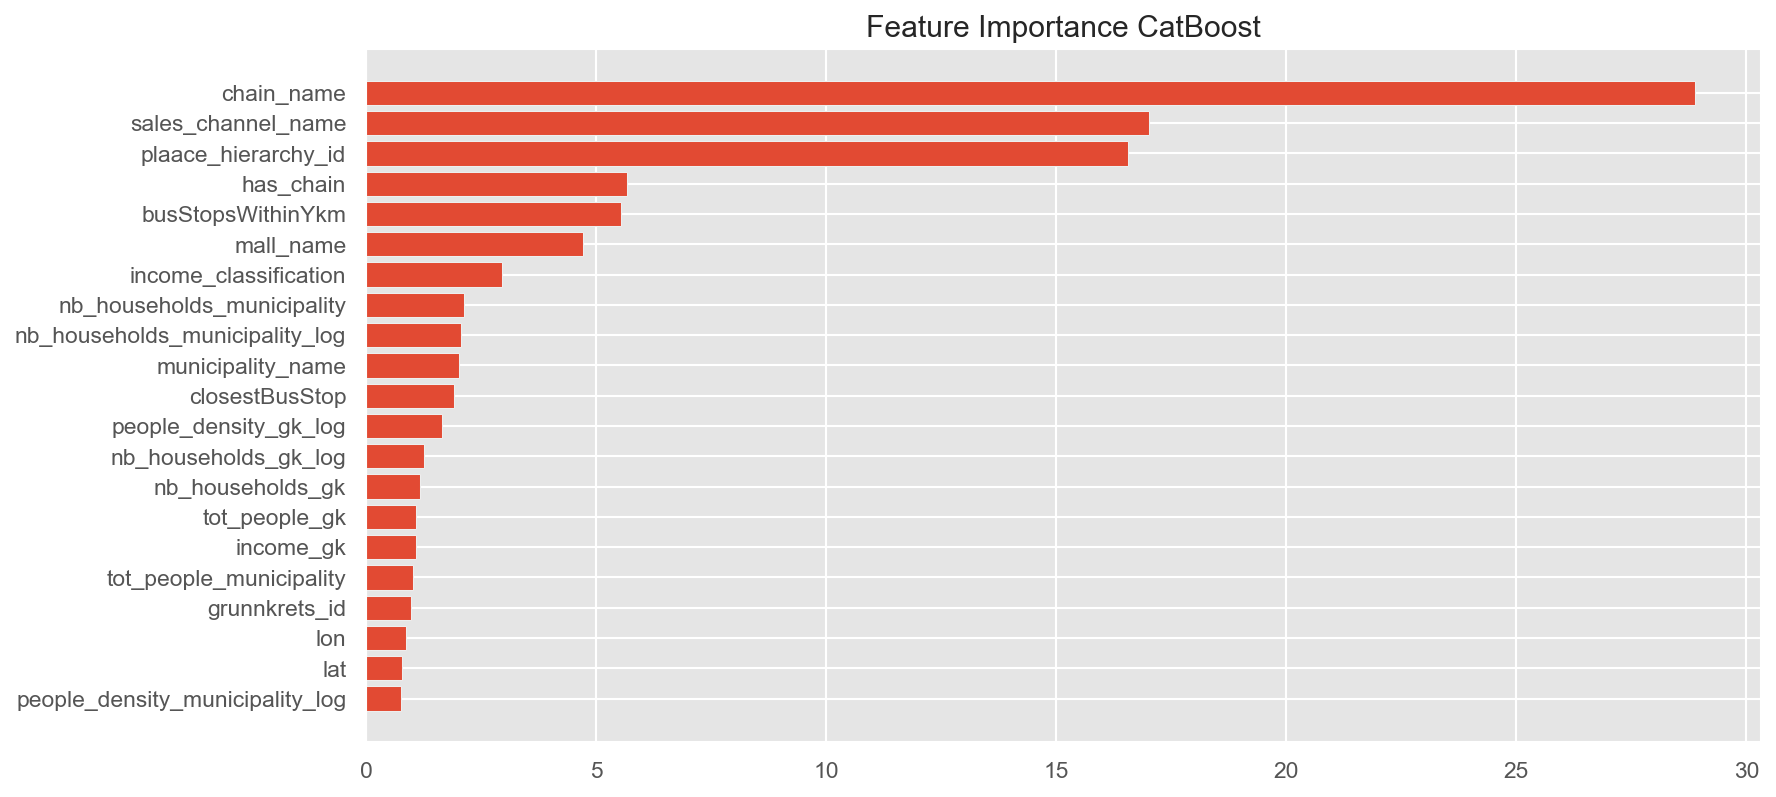

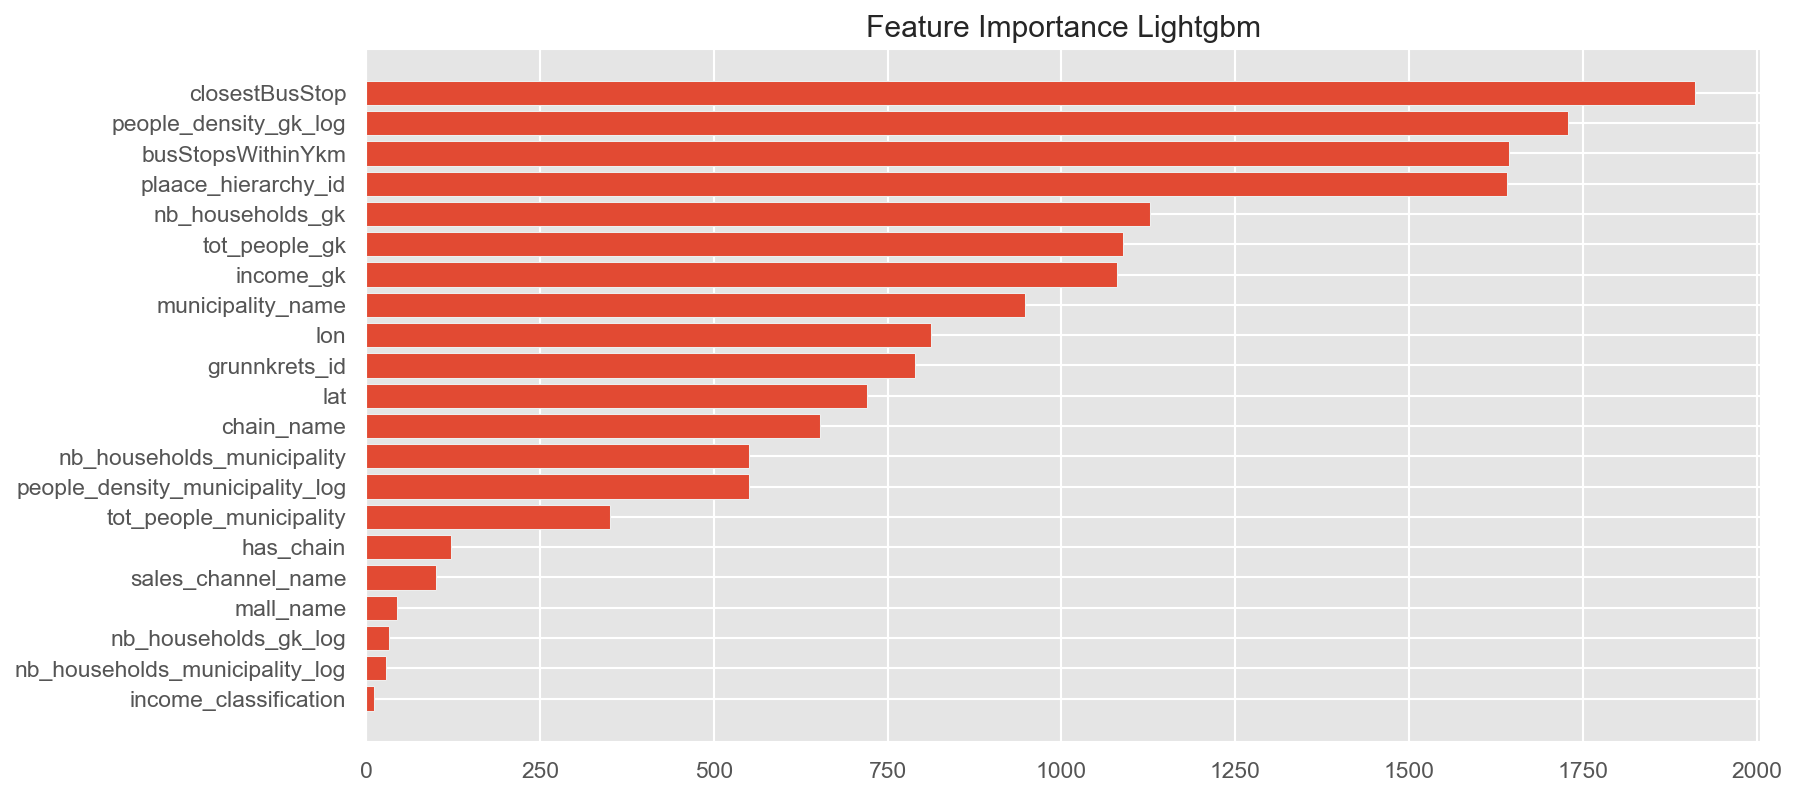

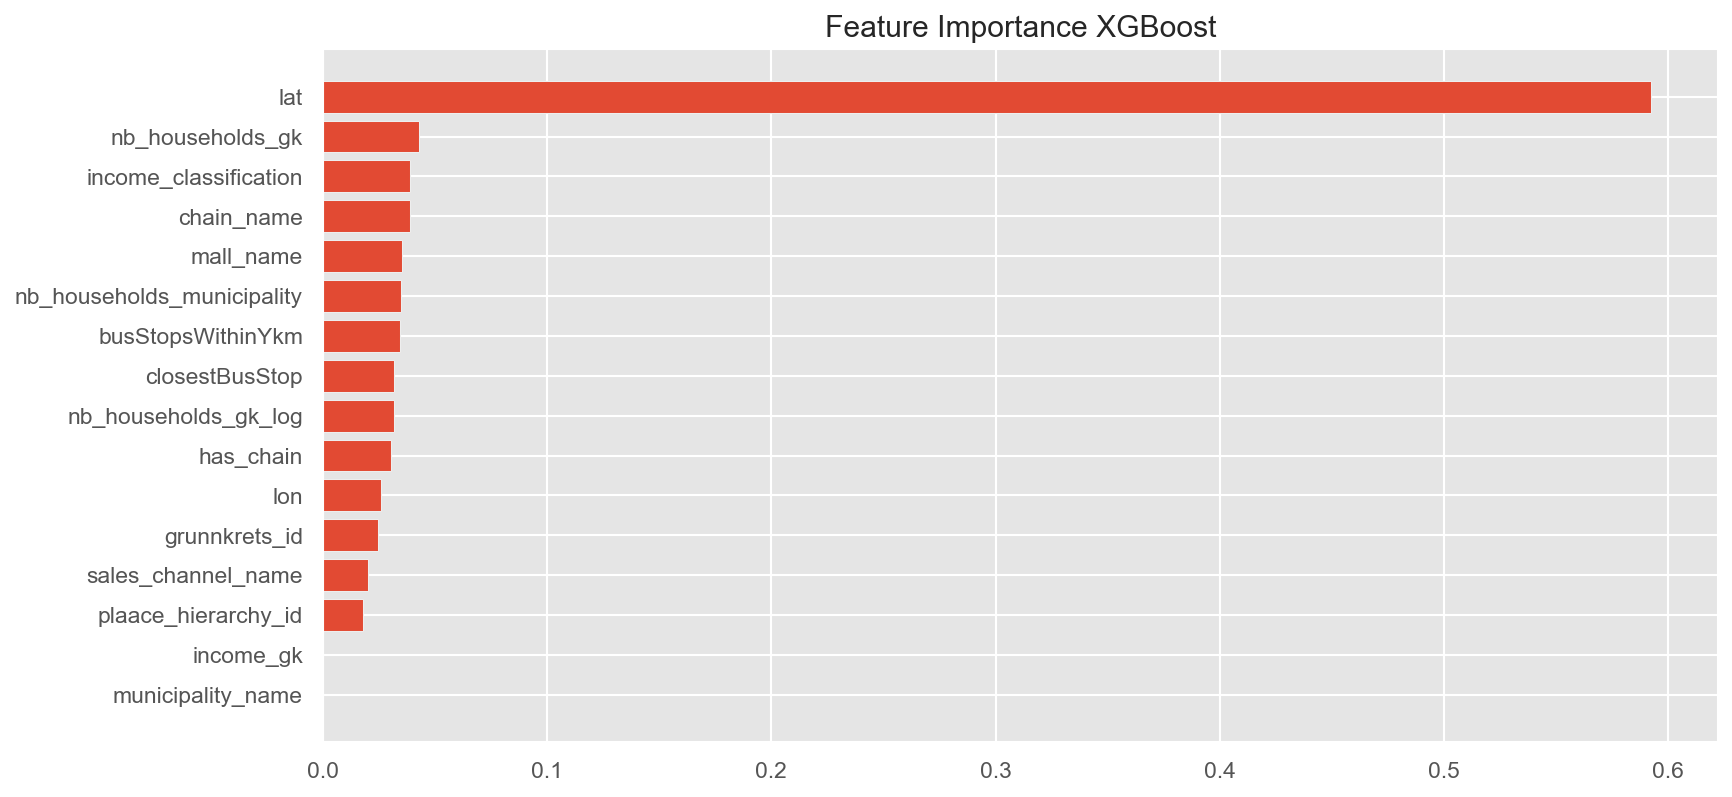

In [285]:
# Feature importance

# lightGBM
#tuner.plot_importances()

# catBoost
#CB_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=categorical_features_indices)
#CB_model.fit(CB_x_train, y_train)

CB_f_imp = CB_model.feature_importances_
sorted_idx = np.argsort(CB_f_imp)

fig = plt.figure(figsize=(12, 6), dpi=150)
plt.barh(range(len(sorted_idx)), CB_f_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance CatBoost')
plt.show()

 
LGBM_f_imp = LGBM_model.feature_importances_
sorted_idx = np.argsort(LGBM_f_imp)

fig = plt.figure(figsize=(12, 6), dpi=150)
plt.barh(range(len(sorted_idx)), LGBM_f_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance Lightgbm')
plt.show()


XG_f_imp = XG_model.feature_importances_
sorted_idx = np.argsort(XG_f_imp)

fig = plt.figure(figsize=(12, 6), dpi=150)
plt.barh(range(len(sorted_idx)), XG_f_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance XGBoost')
plt.show()


In [232]:
tuner.feature_importances

plaace_hierarchy_id                0.13235
sales_channel_name                 0.03084
grunnkrets_id                      0.04654
lat                                0.04654
lon                                0.04735
chain_name                         0.05847
mall_name                          0.02023
has_chain                          0.00192
closestBusStop                     0.09834
busStopsWithinXkm                  0.05391
busStopsWithinYkm                  0.06098
municipality_name                  0.02811
income_gk                          0.06511
income_classification              0.00461
nb_households_gk                   0.05722
nb_households_municipality         0.04049
nb_households_gk_log               0.01043
nb_households_municipality_log     0.00472
tot_people_gk                      0.04934
tot_people_municipality            0.02480
people_density_gk_log              0.07775
people_density_municipality_log    0.03998
dtype: float64

## shap

In [269]:
shap.initjs()
explainer = shap.TreeExplainer(CB_model)
shap_values = explainer.shap_values(CB_x_train)
shap.force_plot(explainer.expected_value, shap_values[3,:], CB_x_train.iloc[3,:])

# 5. Final improved models/predictions

### model 1

In [72]:
#final model 1

### model 2

In [73]:
#final model 2

# Testing


#### RMSLE

In [74]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5
